
**Prediction of helicopter flight paths**
THis project is done as a group with the following members as a part of data challenge as part of a course work
- SHARONE SHIBU 
- PRATHEEK JAIN PRAVEEN 
- ADARSH BABU SOBHA 
- ROHIT PRAVEENA RAJEESH 
  


In [1]:
import numpy as np
#import missingno as msno
import pandas as pd
import tables
import tracemalloc
from contextlib import closing
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import h5py
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gc  # Garbage collector
import joblib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
import psutil  # To monitor memory usage
import os

# 2.2<u style="text-decoration-thickness: 4px;"> **Data Loading**</font></span>

Loading flight data from CSV files (2017-2021) and stores it in an HDF5 file (`flight_data.h5`). It handles large datasets by reading the data in chunks to optimize memory usage.

## <u style="text-decoration-thickness: 4px;">Key Steps:</span>
1. **Setup Paths & Parameters**: Defines paths for input and output data and sets a chunk size to process large files efficiently.
2. **Delete Existing HDF5 File**: Removes any pre-existing HDF5 file to avoid conflicts.
3. **Iterate Over CSV Files**: Loops through monthly CSV files and skips missing files.
4. **Infer Column Types**: Reads a sample of data to infer column types and ensures specific columns (e.g., `icao24`, `flight_id`) are treated as strings.
5. **Process Data in Chunks**: Reads the CSV files in chunks to manage memory and formats the `timestamp` column to UTC.
6. **Append Data to HDF5**: Appends each chunk to an HDF5 file without overwriting, optimizing string column sizes.
7. **Completion Message**: Prints a success message once all data is saved to the HDF5 file.

 Designed for efficient storage and retrieval of large flight datasets in HDF5 format.

In [7]:
import os
import pandas as pd

# Paths
data_dir = "/home/jovyan/data/data_training"
output_h5_path = "flight_data.h5"
dataset_key = "data"
chunk_size = 100_000  # Adjust for efficiency

# **Step 1: Delete existing HDF5 file if present**
if os.path.exists(output_h5_path):
    os.remove(output_h5_path)

# **Step 2: Process CSVs in chunks and append correctly**
with pd.HDFStore(output_h5_path, mode='w') as store:
    for year in range(2017, 2022):
        for month in range(1, 13):
            file_path = os.path.join(data_dir, f"{month}_{year}.csv")

            if not os.path.exists(file_path):
                print(f"Skipping missing file: {file_path}")
                continue

            # Read first few rows to infer column types
            sample_df = pd.read_csv(file_path, nrows=5000, low_memory=False)
            inferred_types = sample_df.dtypes.to_dict()

            # **Ensure proper string handling for key columns**
            string_columns = ['icao24', 'flight_id', 'callsign']
            for col in string_columns:
                inferred_types[col] = str

            # **Process in chunks to avoid memory overload**
            for chunk in pd.read_csv(file_path, chunksize=chunk_size, dtype=inferred_types, parse_dates=['timestamp'], low_memory=False):
                # **Drop any unnamed columns**
                chunk = chunk.loc[:, ~chunk.columns.str.contains('^Unnamed')]

                # **Convert timestamp to standardized format**
                chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], utc=True).dt.tz_localize(None)

                # **Ensure string columns are explicitly set as strings**
                for col in string_columns:
                    if col in chunk:
                        chunk[col] = chunk[col].astype(str)

                # **Append to HDF5 file without overwriting**
                store.append(
                    key='data',
                    value=chunk,
                    format='table',
                    data_columns=True,
                    index=False,
                    min_itemsize={'flight_id': 15, 'callsign': 30, 'icao24': 25}  # Increase sizes
                )

print(f" All data successfully saved to {output_h5_path}")

Skipping missing file: /home/jovyan/data/data_training/8_2017.csv
Skipping missing file: /home/jovyan/data/data_training/9_2017.csv
Skipping missing file: /home/jovyan/data/data_training/10_2018.csv
Skipping missing file: /home/jovyan/data/data_training/11_2018.csv
Skipping missing file: /home/jovyan/data/data_training/12_2018.csv
Skipping missing file: /home/jovyan/data/data_training/1_2019.csv
Skipping missing file: /home/jovyan/data/data_training/2_2019.csv
Skipping missing file: /home/jovyan/data/data_training/3_2019.csv
Skipping missing file: /home/jovyan/data/data_training/4_2020.csv
Skipping missing file: /home/jovyan/data/data_training/5_2020.csv
Skipping missing file: /home/jovyan/data/data_training/6_2021.csv
Skipping missing file: /home/jovyan/data/data_training/7_2021.csv
 All data successfully saved to flight_data.h5


# 2.3<u style="text-decoration-thickness: 4px;">Flight Data Processing and Visualization</span>
Processes flight data stored in an HDF5 file (`flight_data.h5`) and visualizes the distribution of datapoints per flight using a histogram. 
## <u style="text-decoration-thickness: 4px;">Key Steps:</span>

1. **Setup Paths & Parameters**: Defines the file path for the HDF5 dataset and sets the chunk size for optimal performance.
2. **Initialize Count Dictionary**: An empty dictionary (`flight_counts`) is created to keep track of the occurrences of each `flight_id` across all chunks.
3. **Verify Dataset Structure**: The script prints out available keys in the HDF5 file and lists the columns in the dataset to ensure the correct structure.
4. **Process Data in Chunks**: The dataset is read in chunks of 1 million rows at a time to manage large data efficiently. The `flight_id` column is checked, and if missing, an error is raised.
5. **Count Flights**: For each chunk, the script counts how many times each `flight_id` appears and updates the global count in the `flight_counts` dictionary.
6. **Progress Tracking**: The script tracks and displays the number of rows processed so far.
7. **Visualization**: After processing the entire dataset, a histogram is plotted to show the distribution of datapoints per flight.
8. **Print Statistics**: The script prints the total number of entries and the number of unique flights.


Available keys in HDF5: ['/data']
Columns in dataset: ['registration', 'icao24', 'operator', 'callsign', 'alert', 'altitude', 'count', 'geoaltitude', 'groundspeed', 'hour', 'last_position', 'latitude', 'longitude', 'onground', 'spi', 'squawk', 'timestamp', 'track', 'vertical_rate', 'flight_id', 'cumdist', 'compute_gs', 'compute_track', 'month']
Total rows in dataset: 28,543,639
Columns saved as attributes for 'data'.


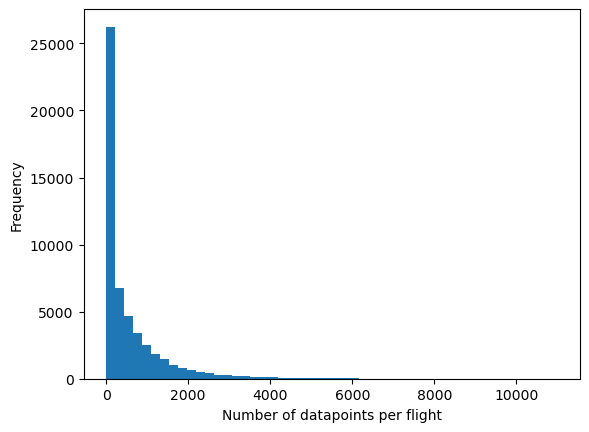

Number of data entries initial: 28543639
Number of flights in total initial: 51991


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
flight_data_h5_path = "flight_data.h5"
dataset_key = "data"
chunk_size = 1_000_000  # Optimal for performance

# Initialize an empty dictionary for counting
flight_counts = {}

# Process in chunks
with pd.HDFStore(flight_data_h5_path, mode='r+') as store:
    # Verify dataset structure
    print("Available keys in HDF5:", store.keys())
    columns = store.get_storer(dataset_key).non_index_axes[0][1]  # Retrieve columns
    print("Columns in dataset:", columns)

    # Get total rows
    total_rows = store.get_storer(dataset_key).nrows
    print(f"Total rows in dataset: {total_rows:,}")

    # Add columns as attributes to the dataset
    if dataset_key in store:
        store.get_storer(dataset_key).attrs['columns'] = columns
        print(f"Columns saved as attributes for '{dataset_key}'.")

    # Read and process chunks
    for chunk_number, chunk in enumerate(store.select(dataset_key, chunksize=chunk_size)):
        # Ensure 'flight_id' column exists
        if 'flight_id' not in chunk.columns:
            raise KeyError("Column 'flight_id' not found in the dataset.")

        # Count flight IDs in this chunk
        chunk_counts = chunk['flight_id'].value_counts(dropna=False).to_dict()

        # Merge counts into the global dictionary
        for flight_id, count in chunk_counts.items():
            flight_counts[flight_id] = flight_counts.get(flight_id, 0) + count

        # Progress tracking
        processed_rows = (chunk_number + 1) * chunk_size
        print(f"Processed {min(processed_rows, total_rows):,} rows...", end='\r')

# Convert to Series
entries_per_flight = pd.Series(flight_counts, dtype=int)

# Plot histogram
entries_per_flight.plot.hist(bins=50)
plt.xlabel('Number of datapoints per flight')
plt.ylabel('Frequency')
plt.show()

# Print stats
n_flights = len(entries_per_flight)
total_entries = entries_per_flight.sum()
print('Number of data entries initial: {}'.format(total_entries))
print('Number of flights in total initial: {}'.format(n_flights))


 **Flight Statistics**:
   - There are **28,543,639** total datapoints in the dataset.
   - A total of **51,991** unique flights are present.



## Key Steps:
1. **Filter Flights**: Retains flights with 300+ entries based on `flight_id`.
2. **Process in Chunks**: Reads the data in chunks of 1M rows, filters by `flight_id`, and appends the filtered data to a new HDF5 file.
3. **Update Statistics**: Tracks total entries, unique flights, and missing values while processing the data.
4. **Final Statistics**: Computes and prints the number of remaining entries, flights, missing values, and their percentages.

In [46]:
import pandas as pd
# File paths
flight_data_h5_path = "flight_data.h5"
filtered_h5_path = "filtered_flight_data.h5"
chunk_size = 1_000_000

# ---------------------------
# NEW: Load flight counts (REQUIRED)
# ---------------------------
flight_counts = {}
with pd.HDFStore(flight_data_h5_path, mode='r') as store:
    for chunk in store.select('data', chunksize=chunk_size):
        counts = chunk['flight_id'].value_counts(dropna=False).to_dict()
        for fid, cnt in counts.items():
            flight_counts[fid] = flight_counts.get(fid, 0) + cnt

entries_per_flight = pd.Series(flight_counts, dtype=int)

# Step 1: Load flights to keep
flights_to_keep = set(entries_per_flight[entries_per_flight >= 300].index)

# *Step 2: Initialize counters*
total_entries_after = 0
unique_flights_after = set()
missing_counts = None  # To accumulate missing values

# *Step 3: Process data in chunks and write filtered data*
with pd.HDFStore(flight_data_h5_path, mode='r') as store_in, pd.HDFStore(filtered_h5_path, mode='w') as store_out:
    for chunk in store_in.select('data', chunksize=chunk_size):
        # Drop unnamed columns if they exist
        chunk = chunk.loc[:, ~chunk.columns.str.contains('^Unnamed')]  
        
        # Filter the chunk by flights_to_keep
        filtered_chunk = chunk[chunk['flight_id'].isin(flights_to_keep)]
        
        if not filtered_chunk.empty:
            # Append filtered chunk to new HDF5 file
            store_out.append(
                key='data',
                value=filtered_chunk,
                format='table',
                data_columns=True,
                index=False,
                min_itemsize={'flight_id': 15, 'callsign': 30, 'icao24': 25}  # Prevent truncation errors
            )

            # Update statistics
            total_entries_after += len(filtered_chunk)
            unique_flights_after.update(filtered_chunk['flight_id'].unique())
            
            # Accumulate missing values
            if missing_counts is None:
                missing_counts = filtered_chunk.isnull().sum()
            else:
                missing_counts += filtered_chunk.isnull().sum()

# *Step 4: Compute final statistics*
n_flights_after = len(unique_flights_after)
missing_percentage = (missing_counts / total_entries_after) * 100

# *Step 5: Print results*
print(f'Number of data entries after deletion: {total_entries_after:,}')
print(f'Number of flights in total after deletion: {n_flights_after:,}')
print(missing_counts)
print(missing_percentage)

FileNotFoundError: ``C:\Users\rohit\final work\flight_data.h5`` does not exist

# <u style="text-decoration-thickness: 4px;">Summary of Flight Data Filtering Results</span>

After filtering the flight data, the following statistics were obtained:

## <u style="text-decoration-thickness: 4px;">Key Metrics:</span>
1. **Number of Data Entries After Deletion**:  
   - Total entries remaining: **26,403,757**
   
2. **Number of Flights After Deletion**:  
   - Total flights remaining: **22,933**

## <u style="text-decoration-thickness: 4px;">Missing Values Summary:</span>
- Some columns have missing values, notably:
   - **Altitude**: **360,210** missing values
   - **Geoaltitude**: **560,568** missing values
   - **Squawk**: **10,245,563** missing values
   - **Cumdist**: **7,244,756** missing values
   - **Compute_gs** and **Compute_track**: **19,667** missing values
- **Percentage of Missing Values**:
   - **1.3 %** of altitude, **2.1 %** of geoaltitude and **0.8%** of ground speed are missing. Since it is a low percentage of data missing it can be managable using mean, median or mode without significantly altering the model performance.
---


# 3.2 <u style="text-decoration-thickness: 4px;">Missing Values in Filtered Flight Data</span>

Processing the filtered flight data (`filtered_flight_data.h5`) to track missing values in the columns `altitude`, `geoaltitude`, and `groundspeed`, and summarizes the missing data.

## <u style="text-decoration-thickness: 4px;">Key Steps:</span>
1. **Process in Chunks**: The data is read in chunks of 1 million rows.
2. **Track Missing Values**: Counts missing values for each column and by `flight_id`.
3. **Summarize Results**: Prints total missing values and identifies flights with the most missing data.


In [14]:
# File path
filtered_h5_path = "filtered_flight_data.h5"

# Chunk size
chunk_size = 1_000_000  # Process in 1M-row chunks

# Initialize missing value counters
total_missing_altitude = 0
total_missing_geoaltitude = 0
total_missing_gs = 0

# Initialize dictionaries to track missing values per flight
missing_altitude_by_flight = {}
missing_geo_by_flight = {}
missing_gs_by_flight = {}

# **Step 1: Process in Chunks**
with pd.HDFStore(filtered_h5_path, mode='r') as store:
    for chunk in store.select('data', chunksize=chunk_size):
        # Compute missing values per chunk
        missing_altitude = chunk['altitude'].isnull()
        missing_geo = chunk['geoaltitude'].isnull()
        missing_gs = chunk['groundspeed'].isnull()

        # Accumulate total missing values
        total_missing_altitude += missing_altitude.sum()
        total_missing_geoaltitude += missing_geo.sum()
        total_missing_gs += missing_gs.sum()

        # Count missing values per flight and update global dictionary
        missing_alt_by_flight = chunk.groupby('flight_id')['altitude'].apply(lambda x: x.isnull().sum())
        missing_geo_by_flight = chunk.groupby('flight_id')['geoaltitude'].apply(lambda x: x.isnull().sum())
        missing_gs_by_flight = chunk.groupby('flight_id')['groundspeed'].apply(lambda x: x.isnull().sum())

        for flight, count in missing_alt_by_flight.items():
            missing_altitude_by_flight[flight] = missing_altitude_by_flight.get(flight, 0) + count

        for flight, count in missing_geo_by_flight.items():
            missing_geo_by_flight[flight] = missing_geo_by_flight.get(flight, 0) + count

        for flight, count in missing_gs_by_flight.items():
            missing_gs_by_flight[flight] = missing_gs_by_flight.get(flight, 0) + count

# **Step 2: Convert missing value dictionaries to Pandas Series**
missing_altitude_by_flight = pd.Series(missing_altitude_by_flight).sort_values(ascending=False)
missing_geo_by_flight = pd.Series(missing_geo_by_flight).sort_values(ascending=False)
missing_gs_by_flight = pd.Series(missing_gs_by_flight).sort_values(ascending=False)

# **Step 3: Print results**
print(f"Total Missing Values in 'altitude': {total_missing_altitude}")
print(f"Total Missing Values in 'geoaltitude': {total_missing_geoaltitude}")
print(f"Total Missing Values in 'groundspeed': {total_missing_gs}")

print("Flights with the Largest Missing Altitude Values:")
print(missing_altitude_by_flight.head(30))

print("Flights with the Largest Missing Geoaltitude Values:")
print(missing_geo_by_flight.head(10))

print("Flights with the Largest Missing Groundspeed Values:")
print(missing_gs_by_flight.head(10))

Total Missing Values in 'altitude': 360210
Total Missing Values in 'geoaltitude': 560568
Total Missing Values in 'groundspeed': 234969
Flights with the Largest Missing Altitude Values:
CHX2_728       4366
CHX15_1177     3555
CHX2_1006      2983
CHX2_838       2831
DHXBA_1518     2460
CHX7_2052      2021
CHX7_1558      1797
BPO431_1629    1325
BPO413_1958     998
BPO410_2165     777
CHX7_1055       702
BPO213_2146     698
CHX17_1228      666
CHX15_1240      643
CHX7_766        636
DHXBA_1249      630
CHX7_1254       629
CHX15_1242      587
BPO413_1954     586
CHX17_1672      585
CHX17_1658      580
CHX15_1416      576
BPO234_891      566
CHX32_1662      554
BPO410_2032     531
CHX7_739        527
CHX7_987        511
BPO213_1997     495
CHX17_2043      495
CHX32_1807      484
dtype: int64
Flights with the Largest Missing Geoaltitude Values:
flight_id
CHX2_728     8732
CHX2_718      404
CHX2_731      312
CHX2_1089     288
CHX2_730      284
CHX2_1092     280
CHX17_805     276
CHX2_716     



# <u style="text-decoration-thickness: 4px;">Total Missing Values:</span>
- **Altitude**: **360,210** missing values
- **Geoaltitude**: **560,568** missing values
- **Groundspeed**: **234,969** missing values

## <u style="text-decoration-thickness: 4px;">Flights with the Most Missing Data:</span>

### 1. **Altitude**:
   - `CHX2_728`: 4,366 missing values
   - `CHX15_1177`: 3,555 missing values
   - `CHX2_1006`: 2,983 missing values
   - `CHX2_838`: 2,831 missing values
   - `DHXBA_1518`: 2,460 missing values

### 2. **Geoaltitude**:
   - `CHX2_728`: 8,732 missing values
   - `CHX2_718`: 404 missing values
   - `CHX2_731`: 312 missing values
   - `CHX2_1089`: 288 missing values
   - `CHX2_730`: 284 missing values

### 3. **Groundspeed**:
   - `CHX2_728`: 8,732 missing values
   - `CHX2_716`: 256 missing values
   - `CHX2_718`: 210 missing values
   - `CHX7_945`: 202 missing values
   - `CHX2_720`: 188 missing values

     ---

# 3.3<u style="text-decoration-thickness: 4px;"> Missing Data Analysis</span>

 Calculating missing data percentages for `altitude`, `geoaltitude`, and `groundspeed` for each flight.

## <u style="text-decoration-thickness: 4px;"> Key Steps:</span>
1. **Process Data in Chunks**: Reads the filtered data in 1M-row chunks, identifying missing values for key columns.
2. **Aggregate by Flight**: Groups data by `flight_id` and aggregates missing values.
3. **Compute Missing Percentages**: Calculates the percentage of missing data for each flight.The percentage of missing values is given by:  
<font size="3">$\text{Missing Percentage} = \left( \frac{\text{Total Missing Values}}{\text{Available Data Points}} \right) \times 100$</font> 
4. **Display Results**: Shows the percentage of missing data for `altitude`, `geoaltitude`, and `groundspeed`.

.

In [15]:
# File path
filtered_h5_path = "filtered_flight_data.h5"

# Chunk size
chunk_size = 1_000_000  # Process in 1M-row chunks

# Initialize dictionaries to track missing values per flight
flight_data = {}

# **Step 1: Process in Chunks**
with pd.HDFStore(filtered_h5_path, mode='r') as store:
    for chunk in store.select('data', chunksize=chunk_size):
        # Compute missing values in the chunk
        chunk['altitude_missing'] = chunk['altitude'].isnull().astype(int)
        chunk['geoaltitude_missing'] = chunk['geoaltitude'].isnull().astype(int)
        chunk['groundspeed_missing'] = chunk['groundspeed'].isnull().astype(int)

        # Group by 'flight_id' and aggregate total/missing values
        grouped = chunk.groupby('flight_id').agg(
            total_data_points=('altitude', 'size'),
            total_missing_altitude=('altitude_missing', 'sum'),
            total_missing_geoaltitude=('geoaltitude_missing', 'sum'),
            total_missing_groundspeed=('groundspeed_missing', 'sum')
        )

        # Accumulate results in a dictionary
        for flight, row in grouped.iterrows():
            if flight not in flight_data:
                flight_data[flight] = row.to_dict()
            else:
                for key in row.index:
                    flight_data[flight][key] += row[key]

# **Step 2: Convert dictionary to DataFrame**
missing_data_summary = pd.DataFrame.from_dict(flight_data, orient='index')

# **Step 3: Compute available data points**
missing_data_summary['available_altitude'] = (
    missing_data_summary['total_data_points'] - missing_data_summary['total_missing_altitude']
)
missing_data_summary['available_geoaltitude'] = (
    missing_data_summary['total_data_points'] - missing_data_summary['total_missing_geoaltitude']
)
missing_data_summary['available_groundspeed'] = (
    missing_data_summary['total_data_points'] - missing_data_summary['total_missing_groundspeed']
)

# **Step 4: Compute missing percentages**
missing_data_summary['missing_altitude_percentage'] = (
    (missing_data_summary['total_missing_altitude'] / missing_data_summary['available_altitude']) * 100
)
missing_data_summary['missing_geoaltitude_percentage'] = (
    (missing_data_summary['total_missing_geoaltitude'] / missing_data_summary['available_geoaltitude']) * 100
)
missing_data_summary['missing_groundspeed_percentage'] = (
    (missing_data_summary['total_missing_groundspeed'] / missing_data_summary['available_groundspeed']) * 100
)

# **Step 5: Display the summary**
print(missing_data_summary[['missing_altitude_percentage', 
                            'missing_geoaltitude_percentage', 
                            'missing_groundspeed_percentage']])


            missing_altitude_percentage  missing_geoaltitude_percentage  \
3DD66F_000                     0.124481                        0.835771   
3DD66F_001                     0.000000                        0.000000   
3DD66F_002                     0.653120                        1.985294   
3DD66F_003                     0.000000                        0.201884   
3DD66F_004                     0.000000                        0.262123   
...                                 ...                             ...   
DHRTA_211                      0.000000                        0.131406   
DHRTA_216                      0.000000                        0.151286   
DHRTA_219                      0.000000                        0.000000   
DHRTA_220                      0.000000                        0.000000   
DHRTA_222                      0.000000                        0.000000   

            missing_groundspeed_percentage  
3DD66F_000                        0.000000  
3DD66F_00

## 3.4 <u style="text-decoration-thickness: 4px;">Top 30 Flights with Largest Missing Data Percentages</span>

Calculating the percentage of missing values for three key columns: `altitude`, `geoaltitude`, and `groundspeed`. The missing data percentages are calculated for each flight, and the top 30 flights with the largest missing percentages for each column are displayed in a table.

### <u style="text-decoration-thickness: 4px;">Key Steps:</span>
1. **Chunk-wise Processing**: The data is processed in 1M-row chunks to compute missing values for `altitude`, `geoaltitude`, and `groundspeed`.
2. **Grouping by Flight ID**: The data is grouped by `flight_id` to aggregate total data points and missing data counts.
3. **Missing Percentages Calculation**: The percentage of missing data is computed for each flight.
4. **Top 30 Flights**: The top 30 flights with the largest missing data percentages for each column are selected.
5. **Visualization**: A table is generated and displayed using matplotlib to visualize the top 30 flights with the largest missing data percentages.

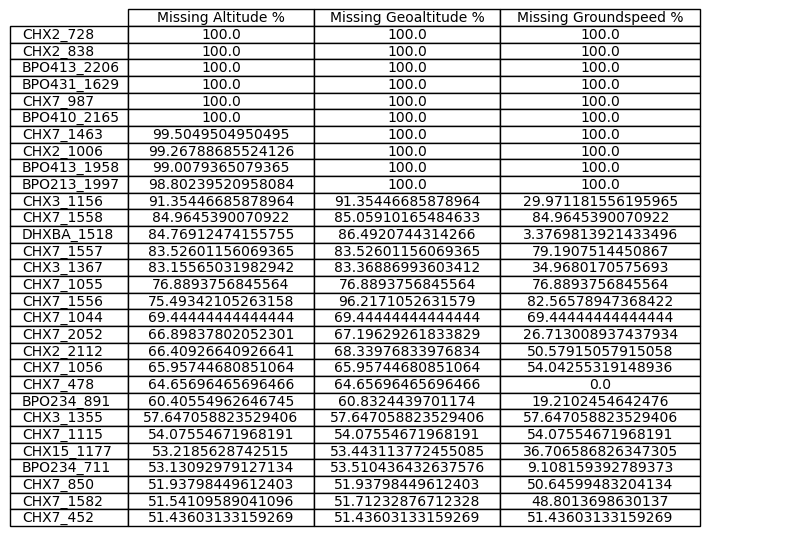

In [16]:
# File path
filtered_h5_path = "filtered_flight_data.h5"

# Chunk size
chunk_size = 1_000_000  # Process in 1M-row chunks

# Initialize dictionary to track missing values per flight
flight_data = {}

# **Step 1: Process in Chunks**
with pd.HDFStore(filtered_h5_path, mode='r') as store:
    for chunk in store.select('data', chunksize=chunk_size):
        # Compute missing values in the chunk
        chunk['altitude_missing'] = chunk['altitude'].isnull().astype(int)
        chunk['geoaltitude_missing'] = chunk['geoaltitude'].isnull().astype(int)
        chunk['groundspeed_missing'] = chunk['groundspeed'].isnull().astype(int)

        # Group by 'flight_id' and aggregate total/missing values
        grouped = chunk.groupby('flight_id').agg(
            total_data_points=('altitude', 'size'),
            total_missing_altitude=('altitude_missing', 'sum'),
            total_missing_geoaltitude=('geoaltitude_missing', 'sum'),
            total_missing_groundspeed=('groundspeed_missing', 'sum')
        )

        # Accumulate results in a dictionary
        for flight, row in grouped.iterrows():
            if flight not in flight_data:
                flight_data[flight] = row.to_dict()
            else:
                for key in row.index:
                    flight_data[flight][key] += row[key]

# **Step 2: Convert dictionary to DataFrame**
missing_data_summary = pd.DataFrame.from_dict(flight_data, orient='index')

# **Step 3: Compute missing percentages**
missing_data_summary['missing_altitude_percentage'] = (
    (missing_data_summary['total_missing_altitude'] / missing_data_summary['total_data_points']) * 100
)
missing_data_summary['missing_geoaltitude_percentage'] = (
    (missing_data_summary['total_missing_geoaltitude'] / missing_data_summary['total_data_points']) * 100
)
missing_data_summary['missing_groundspeed_percentage'] = (
    (missing_data_summary['total_missing_groundspeed'] / missing_data_summary['total_data_points']) * 100
)

# **Step 4: Sort and select top 30 flights with the largest missing percentages**
top_30_altitude = missing_data_summary.sort_values(by='missing_altitude_percentage', ascending=False).head(30)
top_30_geoaltitude = missing_data_summary.sort_values(by='missing_geoaltitude_percentage', ascending=False).head(30)
top_30_groundspeed = missing_data_summary.sort_values(by='missing_groundspeed_percentage', ascending=False).head(30)

# **Step 5: Prepare the figure and axis for visualization**
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Create the table for top 30 flights with the largest missing data
table_data = top_30_altitude[['missing_altitude_percentage', 'missing_geoaltitude_percentage', 'missing_groundspeed_percentage']].values
col_labels = ['Missing Altitude %', 'Missing Geoaltitude %', 'Missing Groundspeed %']
row_labels = top_30_altitude.index

# Create and display the table
table = ax.table(cellText=table_data,
                 colLabels=col_labels,
                 rowLabels=row_labels,
                 loc='center', cellLoc='center', colLoc='center')

# Adjust font size and alignment
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])

# Display the plot with the table
plt.show()


**6** Flights have **100%** of missing values in all 3 parameters

## 3.5 <u style="text-decoration-thickness: 4px;">Summary of Flights with Missing Data</span>

 calculates missing data percentages for three critical columns: `altitude`, `geoaltitude`, and `groundspeed`.and determining how many flights have less than 10% missing data for each of these parameters

### <u style="text-decoration-thickness: 4px;">Key Steps:</span>
1. **Chunk-wise Processing**: The data is processed in chunks of 1 million rows to compute missing values for `altitude`, `geoaltitude`, and `groundspeed`.
2. **Grouping by Flight ID**: The data is grouped by `flight_id`, and total and missing values are aggregated for each flight.
3. **Percentage Calculation**: The missing data percentages for each flight are calculated for the three parameters.
4. **Counting Flights with <10% Missing Values**: The number of flights with less than 10% missing data for each parameter is counted.
5. **Condition Check for All Parameters**: The flights with missing values less than 10% for all three parameters (`altitude`, `geoaltitude`, `groundspeed`) are identified.

In [17]:
# File path
filtered_h5_path = "filtered_flight_data.h5"

# Chunk size
chunk_size = 1_000_000  # Process in 1M-row chunks

# Initialize dictionary to track missing values per flight
flight_data = {}

# **Step 1: Process in Chunks**
with pd.HDFStore(filtered_h5_path, mode='r') as store:
    for chunk in store.select('data', chunksize=chunk_size):
        # Compute missing values in the chunk
        chunk['altitude_missing'] = chunk['altitude'].isnull().astype(int)
        chunk['geoaltitude_missing'] = chunk['geoaltitude'].isnull().astype(int)
        chunk['groundspeed_missing'] = chunk['groundspeed'].isnull().astype(int)

        # Group by 'flight_id' and aggregate total/missing values
        grouped = chunk.groupby('flight_id').agg(
            total_data_points=('altitude', 'size'),
            total_missing_altitude=('altitude_missing', 'sum'),
            total_missing_geoaltitude=('geoaltitude_missing', 'sum'),
            total_missing_groundspeed=('groundspeed_missing', 'sum')
        )

        # Accumulate results in a dictionary
        for flight, row in grouped.iterrows():
            if flight not in flight_data:
                flight_data[flight] = row.to_dict()
            else:
                for key in row.index:
                    flight_data[flight][key] += row[key]

# **Step 2: Convert dictionary to DataFrame**
missing_data_summary = pd.DataFrame.from_dict(flight_data, orient='index')

# **Step 3: Compute missing percentages**
missing_data_summary['missing_altitude_percentage'] = (
    (missing_data_summary['total_missing_altitude'] / missing_data_summary['total_data_points']) * 100
)
missing_data_summary['missing_geoaltitude_percentage'] = (
    (missing_data_summary['total_missing_geoaltitude'] / missing_data_summary['total_data_points']) * 100
)
missing_data_summary['missing_groundspeed_percentage'] = (
    (missing_data_summary['total_missing_groundspeed'] / missing_data_summary['total_data_points']) * 100
)

# **Step 4: Count flights with missing values below 10% for each parameter**
count_less_than_10_altitude = (missing_data_summary['missing_altitude_percentage'] < 10).sum()
count_less_than_10_geoaltitude = (missing_data_summary['missing_geoaltitude_percentage'] < 10).sum()
count_less_than_10_groundspeed = (missing_data_summary['missing_groundspeed_percentage'] < 10).sum()

# Display the results
print(f"Number of flights with missing altitude values less than 10%: {count_less_than_10_altitude}")
print(f"Number of flights with missing geoaltitude values less than 10%: {count_less_than_10_geoaltitude}")
print(f"Number of flights with missing groundspeed values less than 10%: {count_less_than_10_groundspeed}")

# **Step 5: Count flights with all three parameters below 10% missing values**
flights_with_all_missing_less_than_10 = missing_data_summary[
    (missing_data_summary['missing_altitude_percentage'] < 10) &
    (missing_data_summary['missing_geoaltitude_percentage'] < 10) &
    (missing_data_summary['missing_groundspeed_percentage'] < 10)
]

# Total number of flights that meet the condition
total_flights_all_below_10 = flights_with_all_missing_less_than_10.shape[0]

# Display the result
print(f"Total number of flights with all three parameters missing values less than 10%: {total_flights_all_below_10}")
# Save missing_data_summary to the HDF5 file
with pd.HDFStore("filtered_flight_data.h5", mode='a') as store:
    # Save missing_data_summary with a unique key
    store.put('missing_data_summary', missing_data_summary, format='table')

    # Verify that /data and /missing_data_summary both exist
    print(store.keys())  # This will list all keys in the file

Number of flights with missing altitude values less than 10%: 21869
Number of flights with missing geoaltitude values less than 10%: 21431
Number of flights with missing groundspeed values less than 10%: 22344
Total number of flights with all three parameters missing values less than 10%: 21421
['/data', '/missing_data_summary']


## <u style="text-decoration-thickness: 4px;">Results Summary</span>

Here are the key findings after processing the flight data:

- Flights with Missing **Altitude** Values Less Than 10%: **21,869**
- Flights with Missing **Geoaltitude** Values Less Than 10%: **21,431**
- Flights with Missing **Groundspeed** Values Less Than 10%: **22,344**
- Total Flights with **All Three Parameters** Missing **Less Than 10%**: **21,421**

---

## 3.6<u style="text-decoration-thickness: 4px;">Data Processing and Flight Filtering</span>

**Step 1: Filter Data (Chunked Processing)**

- Processing the data in chunks of 500,000 rows at a time, filtering out flights with missing values above 10% for altitude, geoaltitude, or groundspeed. then writing the cleaned data to a new HDF5 file `cleaned_flight_data.h5`.
.

**Step 2: Counting Flights**

- A function `count_unique_flights` is used to count the number of unique flight IDs before and after the deletion of flights with excessive missing data.

In [18]:
import pandas as pd
import numpy as np

# File paths
filtered_h5_path = "filtered_flight_data.h5"
cleaned_h5_path = "cleaned_flight_data.h5"

# Optimized chunk size (adjust based on your RAM)
chunk_size = 500_000  # Increased since we're processing sequentially

# Load flight IDs to delete into a NumPy array for faster lookups
flight_ids_to_delete = missing_data_summary.index[
    (missing_data_summary['missing_altitude_percentage'] >= 10) |
    (missing_data_summary['missing_geoaltitude_percentage'] >= 10) |
    (missing_data_summary['missing_groundspeed_percentage'] >= 10)
].values
flight_ids_to_delete = np.array(flight_ids_to_delete, dtype='object')

# Step 1: Filter data using chunked processing
with pd.HDFStore(filtered_h5_path, 'r') as src_store, \
     pd.HDFStore(cleaned_h5_path, 'w') as dest_store:

    # Get total rows for progress tracking
    total_rows = src_store.get_storer('data').nrows
    
    # Initialize flight counter
    kept_flights = set()
    
    for i, chunk in enumerate(src_store.select('data', chunksize=chunk_size)):
        # Vectorized filtering using NumPy
        mask = ~np.isin(chunk['flight_id'].values, flight_ids_to_delete)
        filtered_chunk = chunk[mask]
        
        # Track kept flights
        kept_flights.update(filtered_chunk['flight_id'].unique())
        
        # Append to HDF5 incrementally
        dest_store.append('data_cleaned', 
                        filtered_chunk,
                        format='table',
                        data_columns=True,
                        min_itemsize={'flight_id': 15, 'callsign': 30, 'icao24': 25},
                        index=False)
        
        # Progress tracking
        processed = min((i+1)*chunk_size, total_rows)
        print(f"Processed {processed:,} of {total_rows:,} rows ({processed/total_rows:.1%})", end='\r')

# Step 2: Optimized flight counting
def count_unique_flights(hdf_path, key):
    """Count unique flight IDs using chunked processing"""
    unique_flights = set()
    with pd.HDFStore(hdf_path, 'r') as store:
        for chunk in store.select(key, chunksize=chunk_size, columns=['flight_id']):
            unique_flights.update(chunk['flight_id'].unique())
    return len(unique_flights)

n_flights_before = count_unique_flights(filtered_h5_path, 'data')
n_flights_after = count_unique_flights(cleaned_h5_path, 'data_cleaned')

print(f"\nNumber of flights before deletion: {n_flights_before}")
print(f"Number of flights after deletion: {n_flights_after}")
print(f"Reduction: {n_flights_before - n_flights_after} flights removed")

Processed 26,403,757 of 26,403,757 rows (100.0%)
Number of flights before deletion: 22933
Number of flights after deletion: 21421
Reduction: 1512 flights removed


### <u style="text-decoration-thickness: 4px;">Final Results:</span>

- **Flights before deletion**: **22,933**
- **Flights after deletion**: **21,421**
- **Total reduction**: **1,512** flights removed.
 ---

## 3.7<u style="text-decoration-thickness: 4px;">Data Reshaping of Cleaned Flight Data into Numeric and Non-Numeric Components</span>
1. **Input and Output Files**: It reads from an existing HDF5 file (`cleaned_flight_data.h5`) and reshapes the data into numeric and non-numeric components, saving them into a new HDF5 file (`reshaped_cleaned_data.h5`).
2. **Chunked Processing**: The data is processed in chunks to handle large datasets efficiently, especially when memory is limited.
3. **Dataset Structure**:
   - Numeric columns are extracted and stored as a 2D array of floats.
   - Non-numeric columns are converted into strings and stored in a separate 2D array.
4. **Final Output**: The reshaped data is saved with two datasets—`data_cleaned_numeric` and `data_cleaned_non_numeric`—which contain the respective data.

In [19]:
import os
import h5py
import numpy as np
import pandas as pd

# File paths
input_h5_path = "cleaned_flight_data.h5"  # Input HDF5 file with 1D data
output_h5_path = "reshaped_cleaned_data.h5"  # Output HDF5 file for 2D data

# Step 1: Open the HDF5 file to extract column names and 1D data
with h5py.File(input_h5_path, "r") as hf:
    # Check if the dataset exists
    if "data_cleaned/table" not in hf:
        raise KeyError("'data_cleaned/table' key is missing in the HDF5 file.")
    dataset = hf["data_cleaned/table"]
    
    # Get column names from the structured array dtype
    column_names = list(dataset.dtype.names)
    print(f"Retrieved column names: {column_names}")
    
    total_rows = dataset.shape[0]
    num_columns = len(column_names)
    print(f"Loaded data with {total_rows} rows and {num_columns} columns")

# Step 2: Process data in chunks and reshape into a 2D array
chunk_size = 100_000  # Adjust based on available memory

# We'll store the final shapes while still inside the context
with h5py.File(input_h5_path, "r") as hf_in, \
     h5py.File(output_h5_path, "w") as hf_out:
    
    dataset_in = hf_in["data_cleaned/table"]
    
    # Create two separate datasets: one for numeric and one for non-numeric
    numeric_columns = []
    non_numeric_columns = []
    
    for name in column_names:
        column_data = dataset_in[name]
        if np.issubdtype(column_data.dtype, np.number):
            numeric_columns.append(name)
        else:
            non_numeric_columns.append(name)
    
    dataset_out_numeric = hf_out.create_dataset(
        "data_cleaned_numeric",
        shape=(total_rows, len(numeric_columns)),
        dtype=np.float64,
        chunks=(chunk_size, len(numeric_columns))
    )
    
    dataset_out_non_numeric = hf_out.create_dataset(
        "data_cleaned_non_numeric",
        shape=(total_rows, len(non_numeric_columns)),
        dtype=h5py.string_dtype(),
        chunks=(chunk_size, len(non_numeric_columns))
    )
    
    hf_out.attrs["numeric_column_names"] = np.array(numeric_columns, dtype=h5py.string_dtype())
    hf_out.attrs["non_numeric_column_names"] = np.array(non_numeric_columns, dtype=h5py.string_dtype())
    
    chunk_start = 0
    while chunk_start < total_rows:
        chunk_end = min(chunk_start + chunk_size, total_rows)
        
        # Read a chunk from the structured array
        struct_chunk = dataset_in[chunk_start:chunk_end]
        
        # Process numeric columns
        numeric_data = [struct_chunk[name].astype(np.float64) for name in numeric_columns]
        # Process non-numeric columns: convert to string using Python's str
        non_numeric_data = [np.array([str(val) for val in struct_chunk[name]]) for name in non_numeric_columns]
        
        # Stack the processed data into 2D arrays
        numeric_chunk = np.column_stack(numeric_data)
        non_numeric_chunk = np.column_stack(non_numeric_data)
        
        # Write the chunks to the respective datasets
        dataset_out_numeric[chunk_start:chunk_end] = numeric_chunk
        dataset_out_non_numeric[chunk_start:chunk_end] = non_numeric_chunk
        
        chunk_start = chunk_end
        print(f"Processed {chunk_end}/{total_rows} rows ({chunk_end/total_rows:.1%})", end="\r")
    
    # Save the shapes before leaving the context
    final_numeric_shape = dataset_out_numeric.shape
    final_non_numeric_shape = dataset_out_non_numeric.shape

print(f"\nReshaped data saved to: {output_h5_path}")
print("Final dataset shapes:")
print("Numeric dataset shape:", final_numeric_shape)
print("Non-numeric dataset shape:", final_non_numeric_shape)

Retrieved column names: ['index', 'registration', 'icao24', 'operator', 'callsign', 'alert', 'altitude', 'count', 'geoaltitude', 'groundspeed', 'hour', 'last_position', 'latitude', 'longitude', 'onground', 'spi', 'squawk', 'timestamp', 'track', 'vertical_rate', 'flight_id', 'cumdist', 'compute_gs', 'compute_track', 'month']
Loaded data with 25158056 rows and 25 columns
Processed 25158056/25158056 rows (100.0%)
Reshaped data saved to: reshaped_cleaned_data.h5
Final dataset shapes:
Numeric dataset shape: (25158056, 18)
Non-numeric dataset shape: (25158056, 7)


### Reshaping Summary
- **Column Names Retrieved**: ['index', 'registration', 'icao24', 'operator', 'callsign', 'alert', 'altitude', 'count', 'geoaltitude', 'groundspeed', 'hour', 'last_position', 'latitude', 'longitude', 'onground', 'spi', 'squawk', 'timestamp', 'track', 'vertical_rate', 'flight_id', 'cumdist', 'compute_gs', 'compute_track', 'month']
- **Total Rows**: 25,158,056
- **Total Columns**: 25

### Data Reshaping:
- **Numeric Data**: 18 columns reshaped and stored in the numeric dataset
- **Non-Numeric Data**: 7 columns reshaped and stored in the non-numeric dataset

**Output Saved to**: `reshaped_cleaned_data.h5`
- **Numeric Dataset Shape**: (25,158,056, 18)
- **Non-Numeric Dataset Shape**: (25,158,056, 7)

# 3.8 <u style="text-decoration-thickness: 4px;">Data Inspection </span>

- **Numeric Dataset**:
    - **Columns**: Retrieved from the `numeric_column_names` attribute
    - **Shape**: (25,158,056 rows, 18 columns)
    - **First 5 rows**: Displayed numeric data for inspection.

- **Non-Numeric Dataset**:
    - **Columns**: Retrieved from the `non_numeric_column_names` attribute
    - **Shape**: (25,158,056 rows, 7 columns)
    - **First 5 rows**: Displayed non-numeric data for inspection.


In [20]:
import h5py
import numpy as np

# Path to reshaped HDF5 file
reshaped_h5_path = "reshaped_cleaned_data.h5"

with h5py.File(reshaped_h5_path, "r") as hf:
    # Check datasets
    if "data_cleaned_numeric" not in hf or "data_cleaned_non_numeric" not in hf:
        raise KeyError("Numeric or non-numeric dataset is missing in the reshaped file.")

    # Load numeric dataset
    numeric_dataset = hf["data_cleaned_numeric"]
    # Load numeric column names directly without decoding
    numeric_columns = hf.attrs["numeric_column_names"]
    print("Numeric columns:", numeric_columns)
    print("Numeric dataset shape:", numeric_dataset.shape)

    # Load non-numeric dataset
    non_numeric_dataset = hf["data_cleaned_non_numeric"]
    # Load non-numeric column names directly without decoding
    non_numeric_columns = hf.attrs["non_numeric_column_names"]
    print("Non-numeric columns:", non_numeric_columns)
    print("Non-numeric dataset shape:", non_numeric_dataset.shape)

    # Show first 5 rows from both datasets
    print("\nFirst 5 rows of numeric data:")
    print(numeric_dataset[:5])

    print("\nFirst 5 rows of non-numeric data:")
    print(non_numeric_dataset[:5])


Numeric columns: ['index' 'alert' 'altitude' 'count' 'geoaltitude' 'groundspeed' 'latitude'
 'longitude' 'onground' 'spi' 'squawk' 'timestamp' 'track' 'vertical_rate'
 'cumdist' 'compute_gs' 'compute_track' 'month']
Numeric dataset shape: (25158056, 18)
Non-numeric columns: ['registration' 'icao24' 'operator' 'callsign' 'hour' 'last_position'
 'flight_id']
Non-numeric dataset shape: (25158056, 7)

First 5 rows of numeric data:
[[1.58100000e+03 0.00000000e+00 7.75000000e+02 2.00000000e+00
  7.75000000e+02 9.10000000e+01 5.34732987e+01 9.94537354e+00
  0.00000000e+00 0.00000000e+00            nan 1.48326970e+18
  3.77228360e+00 3.20000000e+02            nan            nan
             nan 1.00000000e+00]
 [1.58200000e+03 0.00000000e+00 7.75000000e+02 2.00000000e+00
  7.75000000e+02 9.10000000e+01 5.34732987e+01 9.94537354e+00
  0.00000000e+00 0.00000000e+00            nan 1.48326970e+18
  3.77228360e+00 3.20000000e+02            nan 0.00000000e+00
  1.80000000e+02 1.00000000e+00]
 [1.583

In [21]:
# Paths
input_h5_path = "reshaped_cleaned_data.h5"

# Step 1: Inspect the input file and check available keys
with h5py.File(input_h5_path, 'r') as hf:
    print("Datasets in input file:")
    for key in hf.keys():
        print(key)  # This will print all the top-level keys in the HDF5 file

# Inspect the input file and check for the type of 'data_cleaned_numeric' and 'data_cleaned_non_numeric'
with h5py.File(input_h5_path, 'r') as hf:
    # Check if 'data_cleaned_numeric' and 'data_cleaned_non_numeric' exist
    if 'data_cleaned_numeric' in hf:
        print(f"Found 'data_cleaned_numeric'. Is it a group or dataset?")
        print(f"Type: {type(hf['data_cleaned_numeric'])}")  # Print type (Group or Dataset)
    else:
        print("'data_cleaned_numeric' does not exist in the file.")

    if 'data_cleaned_non_numeric' in hf:
        print(f"Found 'data_cleaned_non_numeric'. Is it a group or dataset?")
        print(f"Type: {type(hf['data_cleaned_non_numeric'])}")  # Print type (Group or Dataset)
    else:
        print("'data_cleaned_non_numeric' does not exist in the file.")

# Inspect the columns of each dataset
with h5py.File(input_h5_path, 'r') as hf:
    # Check the numeric columns
    if 'data_cleaned_numeric' in hf:
        ds_numeric = hf['data_cleaned_numeric']
        # Retrieve column names from the stored attribute
        numeric_column_names = hf.attrs.get("numeric_column_names", None)
        if numeric_column_names is not None:
            print("Actual numeric column names in HDF5:", numeric_column_names)
        else:
            print("Numeric column names attribute is missing.")
    
    # Check the non-numeric columns
    if 'data_cleaned_non_numeric' in hf:
        ds_non_numeric = hf['data_cleaned_non_numeric']
        # Retrieve column names from the stored attribute
        non_numeric_column_names = hf.attrs.get("non_numeric_column_names", None)
        if non_numeric_column_names is not None:
            print("Actual non-numeric column names in HDF5:", non_numeric_column_names)
        else:
            print("Non-numeric column names attribute is missing.")

Datasets in input file:
data_cleaned_non_numeric
data_cleaned_numeric
Found 'data_cleaned_numeric'. Is it a group or dataset?
Type: <class 'h5py._hl.dataset.Dataset'>
Found 'data_cleaned_non_numeric'. Is it a group or dataset?
Type: <class 'h5py._hl.dataset.Dataset'>
Actual numeric column names in HDF5: ['index' 'alert' 'altitude' 'count' 'geoaltitude' 'groundspeed' 'latitude'
 'longitude' 'onground' 'spi' 'squawk' 'timestamp' 'track' 'vertical_rate'
 'cumdist' 'compute_gs' 'compute_track' 'month']
Actual non-numeric column names in HDF5: ['registration' 'icao24' 'operator' 'callsign' 'hour' 'last_position'
 'flight_id']


**Two separate datasets have been created namely numeric and non-numeric data set to access data more efficiently.**

----------

In [22]:
import os
import h5py
import pandas as pd
import numpy as np
import gc

# Paths
input_h5_path = "reshaped_cleaned_data.h5"
flight_id_h5_path = "flight_id_converted.h5"

# Settings
chunk_size = 1_000_000

# Delete existing file if it exists
if os.path.exists(flight_id_h5_path):
    os.remove(flight_id_h5_path)

print("Converting and saving 'flight_id' column...")

max_flight_id_length = 0

with h5py.File(input_h5_path, 'r') as hf_in, h5py.File(flight_id_h5_path, 'w') as hf_out:
    # --------------------------------------------------------------------------
    # STEP 1: Find where the columns live and inspect metadata
    # --------------------------------------------------------------------------
    if "data_cleaned_numeric" not in hf_in or "data_cleaned_non_numeric" not in hf_in:
        raise KeyError("Both 'data_cleaned_numeric' and 'data_cleaned_non_numeric' must exist in the input file.")

    ds_numeric = hf_in["data_cleaned_numeric"]
    ds_non_numeric = hf_in["data_cleaned_non_numeric"]

    numeric_cols = list(hf_in.attrs.get("numeric_column_names", []))
    non_numeric_cols = list(hf_in.attrs.get("non_numeric_column_names", []))

    print("Numeric columns:", numeric_cols)
    print("Non-numeric columns:", non_numeric_cols)

    # Ensure necessary columns exist
    if "flight_id" not in non_numeric_cols:
        raise KeyError("'flight_id' must be in the non-numeric dataset.")
    if "timestamp" not in numeric_cols:
        raise KeyError("'timestamp' must be in the numeric dataset.")

    # Get column indices
    flight_id_idx = non_numeric_cols.index("flight_id")
    timestamp_idx = numeric_cols.index("timestamp")

    # Create output dataset
    total_rows = ds_non_numeric.shape[0]
    if total_rows != ds_numeric.shape[0]:
        raise ValueError("Mismatch in the number of rows between numeric and non-numeric datasets.")

    ds_out = hf_out.create_dataset(
        'flight_id',
        shape=(0,),  # Start with an empty dataset
        maxshape=(None,),  # Allow resizing
        dtype=h5py.string_dtype(encoding='utf-8'),
        chunks=True
    )

    # --------------------------------------------------------------------------
    # STEP 2: Process chunks and apply the logic
    # --------------------------------------------------------------------------
    for start in range(0, total_rows, chunk_size):
        end = min(start + chunk_size, total_rows)

        # Read data for the current chunk
        flight_ids = ds_non_numeric[start:end, flight_id_idx].astype(str)
        timestamps = ds_numeric[start:end, timestamp_idx]

        print(f"Processing rows {start} to {end}...")  # Debugging statement

        # Convert nanosecond timestamps to seconds
        timestamps_in_seconds = timestamps / 1e9  # Convert nanoseconds to seconds

        # Convert to pandas datetime
        # Ensure timestamps are a pandas Series for consistent `.dt` functionality
        df_times = pd.Series(pd.to_datetime(timestamps_in_seconds, unit='s', errors='coerce'))

        # Extract year_month in YYYY_MM format
        if not isinstance(df_times, pd.Series):
            df_times = pd.Series(df_times)  # Ensure it's a Series for `.dt` to work
        year_month = df_times.dt.strftime('%Y_%m')

        # Handle invalid timestamps
        valid_mask = ~df_times.isna()
        valid_flight_ids = flight_ids[valid_mask]
        valid_year_month = year_month[valid_mask]

        # Modify the flight_id column
        # Use list comprehension for concatenation
        new_flight_ids = [f"{fid}_{ym}" for fid, ym in zip(valid_flight_ids, valid_year_month)]


        # Track max length of flight_id
        current_max = max(len(fid) for fid in new_flight_ids) if len(new_flight_ids) > 0 else 0
        max_flight_id_length = max(max_flight_id_length, current_max)

        # Resize and append to output dataset
        ds_out.resize(ds_out.shape[0] + len(new_flight_ids), axis=0)
        ds_out[-len(new_flight_ids):] = np.array(new_flight_ids, dtype=h5py.string_dtype())

    print(f"Max flight_id length: {max_flight_id_length}")

# --------------------------------------------------------------------------
# STEP 3: Verify the output
# --------------------------------------------------------------------------
print("Verification:")
with h5py.File(flight_id_h5_path, 'r') as hf:
    dataset = hf["flight_id"]
    print(f"Shape of dataset: {dataset.shape}")
    print("Top 5 rows:")
    print(dataset[:5].astype(str))  # Retrieve first 5 rows


Converting and saving 'flight_id' column...
Numeric columns: ['index', 'alert', 'altitude', 'count', 'geoaltitude', 'groundspeed', 'latitude', 'longitude', 'onground', 'spi', 'squawk', 'timestamp', 'track', 'vertical_rate', 'cumdist', 'compute_gs', 'compute_track', 'month']
Non-numeric columns: ['registration', 'icao24', 'operator', 'callsign', 'hour', 'last_position', 'flight_id']
Processing rows 0 to 1000000...
Processing rows 1000000 to 2000000...
Processing rows 2000000 to 3000000...
Processing rows 3000000 to 4000000...
Processing rows 4000000 to 5000000...
Processing rows 5000000 to 6000000...
Processing rows 6000000 to 7000000...
Processing rows 7000000 to 8000000...
Processing rows 8000000 to 9000000...
Processing rows 9000000 to 10000000...
Processing rows 10000000 to 11000000...
Processing rows 11000000 to 12000000...
Processing rows 12000000 to 13000000...
Processing rows 13000000 to 14000000...
Processing rows 14000000 to 15000000...
Processing rows 15000000 to 16000000...


This code is designed to process the flight_id column from an HDF5 dataset and make it unique by appending a timestamp in the YYYY_MM format. The need for this arises because flight_id values repeat across different months, meaning they are not globally unique. However, within a particular month, they are unique. To address this, the code reads flight_id and timestamp data in chunks to handle large datasets efficiently. It converts the nanosecond-level timestamps to seconds, extracts the year and month as a string, and appends this YYYY_MM suffix to each flight_id. This ensures that every flight_id is unique across the entire dataset. The transformed flight_id values are then saved into a new HDF5 file, dynamically resizing the output dataset as necessary.

---------

In [23]:
input_h5_path = "reshaped_cleaned_data.h5"  
with h5py.File(input_h5_path, 'r') as hf:
    ds = hf['data_cleaned_numeric']
    print("Dataset dtype:", ds.dtype)  # For structured arrays
    print("Column names:", hf.attrs["numeric_column_names"])

Dataset dtype: float64
Column names: ['index' 'alert' 'altitude' 'count' 'geoaltitude' 'groundspeed' 'latitude'
 'longitude' 'onground' 'spi' 'squawk' 'timestamp' 'track' 'vertical_rate'
 'cumdist' 'compute_gs' 'compute_track' 'month']


In [24]:
import os
import h5py
import numpy as np

# File paths
input_h5_path = "reshaped_cleaned_data.h5"  # Source of cleaned data
subset_h5_path = "float_columns_subset.h5"  # New output file
chunk_size = 500_000  # Process in chunks

# Columns to drop
columns_to_drop = ['index', 'alert', 'count', 'onground', 'spi', 'month','timestamp','squawk']

# Clean up existing output file
if os.path.exists(subset_h5_path):
    os.remove(subset_h5_path)

# Step 1: Identify float64 columns from the numeric dataset
with h5py.File(input_h5_path, mode='r') as hf:
    # Check if the numeric dataset exists
    if 'data_cleaned_numeric' not in hf:
        raise KeyError("'data_cleaned_numeric' dataset is missing in the input file.")
    
    # Retrieve the numeric dataset
    ds_numeric = hf["data_cleaned_numeric"]
    
    # Retrieve column names from file attributes
    numeric_column_names = hf.attrs.get("numeric_column_names", None)
    if numeric_column_names is None:
        raise KeyError("'numeric_column_names' attribute is missing in the HDF5 file.")
    
    # Decode column names if stored as bytes
    numeric_column_names = [name.decode("utf-8") if isinstance(name, bytes) else name for name in numeric_column_names]
    
    # Get the data type of the dataset
    dtype_sample = ds_numeric.dtype
    
    # Check if the dataset has named fields
    if dtype_sample.fields is not None:
        # If fields exist, extract float64 columns
        float_cols = [
            col for col, dtype in dtype_sample.fields.items()
            if np.issubdtype(dtype[0], np.float64)
        ]
    else:
        # If no fields, assume a plain NumPy array and check column-wise types
        first_row = ds_numeric[0]
        float_cols = [
            col for col, value in zip(numeric_column_names, first_row)
            if isinstance(value, (float, np.float64))
        ]
    
    if not float_cols:
        raise ValueError("No float64 columns found in 'data_cleaned_numeric'.")

# Step 2: Remove the columns that need to be dropped
columns_to_keep = [col for col in numeric_column_names if col not in columns_to_drop]
float_cols_to_keep = [col for col in float_cols if col in columns_to_keep]

# Step 3: Process data in chunks and save only float64 columns, ensuring the correct shape
with h5py.File(input_h5_path, mode='r') as hf_in, h5py.File(subset_h5_path, mode='w') as hf_out:
    ds_numeric = hf_in["data_cleaned_numeric"]
    total_rows = ds_numeric.shape[0]
    processed_rows = 0

    # Get indices of float columns to keep
    float_col_indices = [numeric_column_names.index(col) for col in float_cols_to_keep]
    
    # Create output dataset for float columns
    ds_out = hf_out.create_dataset(
        "float_columns",
        shape=(0, len(float_cols_to_keep)),  # Start with zero rows
        maxshape=(None, len(float_cols_to_keep)),  # Allow resizing
        dtype=np.float64,  # Float64 dtype
        chunks=(chunk_size, len(float_cols_to_keep))
    )

    # Save the numeric column names as an attribute in the output file
    hf_out.attrs["feature_names"] = np.array(float_cols_to_keep, dtype="S")

    # Process and save float columns in chunks
    for start in range(0, total_rows, chunk_size):
        end = min(start + chunk_size, total_rows)
        # Extract only the float columns by indexing
        chunk = ds_numeric[start:end, float_col_indices]

        # Resize the output dataset and append chunk
        ds_out.resize(ds_out.shape[0] + chunk.shape[0], axis=0)
        ds_out[-chunk.shape[0]:] = chunk

        processed_rows += chunk.shape[0]
        print(f"Processed {processed_rows:,}/{total_rows:,} rows ({processed_rows / total_rows:.1%})", end='\r')
print(f"\nFloat columns successfully saved to {subset_h5_path}")
# Retrieve feature names and shape from the output file
with h5py.File(subset_h5_path, "r") as hf_out:
    feature_names = hf_out.attrs["feature_names"]
    dataset_shape = hf_out["float_columns"].shape

print("Feature Names:", feature_names)
print("Dataset Shape:", dataset_shape)


Processed 25,158,056/25,158,056 rows (100.0%)
Float columns successfully saved to float_columns_subset.h5
Feature Names: [b'altitude' b'geoaltitude' b'groundspeed' b'latitude' b'longitude'
 b'track' b'vertical_rate' b'cumdist' b'compute_gs' b'compute_track']
Dataset Shape: (25158056, 10)


This step is essential for preparing a streamlined dataset that retains only the float columns, which are typically the most relevant for numerical computations, such as feature selection and model training in machine learning workflows. The original dataset may contain a mix of data types (e.g., numeric, categorical, or metadata), and many columns (such as 'index', 'timestamp', or 'squawk') might not directly contribute to the predictive power of a model or could add unnecessary complexity. By extracting only the float64 columns and discarding irrelevant or redundant ones, this code ensures that the dataset is optimized for downstream tasks.

-----------

In [27]:
import os
import h5py
import pandas as pd
import numpy as np

# Define constants
subset_h5_path = "float_columns_subset.h5"  # Path to the HDF5 file with the float64 subset
output_h5_path = "float_columns_imputed.h5"  # Path to save the imputed float64 data
window_size = 10  # Window size for moving average

# Delete the output file if it exists
if os.path.exists(output_h5_path):
    os.remove(output_h5_path)

# Initialize total NaN counts dictionaries
total_missing_before = {}
total_missing_after = {}

# Open the input HDF5 file for reading and the output HDF5 file for writing
with h5py.File(subset_h5_path, "r") as hf_in, h5py.File(output_h5_path, "w") as hf_out:
    # Access the float_columns dataset
    dataset_in = hf_in["float_columns"]
    print(f"Dataset shape: {dataset_in.shape}")
    
    # Extract feature names from the attributes of the input file
    feature_names = hf_in.attrs["feature_names"]
    print(f"Feature names: {feature_names}")
    
    # Create an output dataset with the same shape and dtype
    dataset_out = hf_out.create_dataset(
        "float_columns",
        shape=dataset_in.shape,
        dtype=dataset_in.dtype,
        chunks=True
    )

    # Save feature names as an attribute in the output file
    hf_out.attrs["feature_names"] = feature_names
    print(f"Feature names copied to the output file.")
    
    # Initialize total NaN counts for each feature name
    total_missing_before = {name: 0 for name in feature_names}
    total_missing_after = {name: 0 for name in feature_names}
    
    # Process in chunks for memory efficiency
    chunk_size = 100_000  # Adjust as needed
    num_rows, num_cols = dataset_in.shape

    for chunk_start in range(0, num_rows, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_rows)
                
        # Read the chunk from the input dataset and create a DataFrame
        chunk = pd.DataFrame(dataset_in[chunk_start:chunk_end], columns=feature_names)
        
        # Process each column in the chunk
        for col in chunk.columns:
            # Update total NaN counts for this chunk
            total_missing_before[col] += chunk[col].isnull().sum()
            
            # Apply moving average to impute missing values
            chunk[col] = chunk[col].fillna(
                chunk[col].rolling(window=window_size, min_periods=1).mean()
            )
            
            chunk[col] = chunk[col].ffill()
            chunk[col] = chunk[col].bfill()
            
            # Update total NaN counts after imputation
            total_missing_after[col] += chunk[col].isnull().sum()
        
        # Write the imputed chunk to the output dataset
        dataset_out[chunk_start:chunk_end] = chunk.values

# Print the total NaN counts for each column
print("\nTotal NaN counts per column:")
for col in feature_names:
    print(f"Feature '{col}':")
    print(f"  NaN before imputation: {total_missing_before[col]}")
    print(f"  NaN after imputation: {total_missing_after[col]}")

print(f"\nImputation completed. Imputed data saved to {output_h5_path}.")


Dataset shape: (25158056, 10)
Feature names: [b'altitude' b'geoaltitude' b'groundspeed' b'latitude' b'longitude'
 b'track' b'vertical_rate' b'cumdist' b'compute_gs' b'compute_track']
Feature names copied to the output file.

Total NaN counts per column:
Feature 'b'altitude'':
  NaN before imputation: 172275
  NaN after imputation: 0
Feature 'b'geoaltitude'':
  NaN before imputation: 255819
  NaN after imputation: 0
Feature 'b'groundspeed'':
  NaN before imputation: 64708
  NaN after imputation: 0
Feature 'b'latitude'':
  NaN before imputation: 0
  NaN after imputation: 0
Feature 'b'longitude'':
  NaN before imputation: 0
  NaN after imputation: 0
Feature 'b'track'':
  NaN before imputation: 64708
  NaN after imputation: 0
Feature 'b'vertical_rate'':
  NaN before imputation: 69428
  NaN after imputation: 0
Feature 'b'cumdist'':
  NaN before imputation: 6685084
  NaN after imputation: 0
Feature 'b'compute_gs'':
  NaN before imputation: 18315
  NaN after imputation: 0
Feature 'b'compute_t

This step is critical for handling missing values in the dataset to ensure data quality and consistency, especially when preparing it for machine learning or statistical analysis. Missing values (NaNs) in numerical data can cause issues such as biased results, inaccurate model predictions, or errors in computations. By applying imputation, this code replaces missing values with meaningful estimates using a moving average, which smooths out fluctuations and preserves data trends. Additionally, forward-fill and backward-fill methods are used to fill any remaining gaps, ensuring no NaNs are left.

----------

## 3.9<u style="text-decoration-thickness: 4px;"> IQR-Based Outlier Detection</span>

#### **Overview**
- Detects outliers in floating-point columns using the **Interquartile Range (IQR) method**.
- Processes data in **chunks** for efficiency.

#### **Method**
1. **Load Data**: Extract feature names & dataset dimensions.
2. **Apply IQR Detection**:
   - Compute **rolling IQR** (window = `24`).
   - Identify values **outside 1.5x IQR bounds**.
3. **Save Outlier Mask**: Store boolean flags (`True` = outlier) in `"float_columns_outliers_iqr.h5"`.

 *Efficient, scalable method for large datasets!*

In [28]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress tracking

# Input and Output File Paths
imputed_h5_path = "float_columns_imputed.h5"
outliers_h5_path = "float_columns_outliers_iqr.h5"

# IQR Detection Parameters
window_size = 24  # Rolling window size, adjust based on data
iqr_multiplier = 1.5  # Threshold multiplier for IQR

# Chunk size for memory-efficient processing
chunk_size = 100_000  # Adjust based on available memory

# Load metadata from HDF5
with h5py.File(imputed_h5_path, "r") as hf:
    feature_names = list(hf.attrs.get("feature_names", []))
    num_rows, num_cols = hf["float_columns"].shape

# Open HDF5 files for reading and writing
with h5py.File(imputed_h5_path, "r") as hf_in, h5py.File(outliers_h5_path, "w") as hf_out:
    dataset_in = hf_in["float_columns"]
    
    # Create an output dataset for the outlier mask (boolean array)
    outlier_mask = hf_out.create_dataset(
        "outlier_mask", 
        shape=(num_rows, num_cols), 
        dtype=bool, 
        chunks=True  # Enable chunking for efficient I/O
    )
    hf_out.attrs["feature_names"] = np.array(feature_names, dtype=h5py.special_dtype(vlen=str))

    # Process data in chunks
    print("Detecting outliers using IQR Method in chunks:")
    for chunk_start in tqdm(range(0, num_rows, chunk_size), desc="Processing chunks"):
        chunk_end = min(chunk_start + chunk_size, num_rows)
        chunk_data = pd.DataFrame(
            dataset_in[chunk_start:chunk_end], 
            columns=feature_names
        )
        
        # Initialize an outlier mask for the chunk
        chunk_outliers = pd.DataFrame(index=chunk_data.index, columns=feature_names, dtype=bool)
        
        # Apply IQR-based outlier detection to each column
        for feature in feature_names:
            series = chunk_data[feature]
            
            # Compute rolling quantiles
            rolling_q1 = series.rolling(window=window_size, min_periods=1).quantile(0.25)
            rolling_q3 = series.rolling(window=window_size, min_periods=1).quantile(0.75)
            iqr = rolling_q3 - rolling_q1
            
            # Compute bounds
            lower_bound = rolling_q1 - iqr_multiplier * iqr
            upper_bound = rolling_q3 + iqr_multiplier * iqr
            
            # Identify outliers
            chunk_outliers[feature] = (series < lower_bound) | (series > upper_bound)
        
        # Write the outlier mask for the chunk to the output HDF5 file
        outlier_mask[chunk_start:chunk_end] = chunk_outliers.values

print(f"Outlier detection completed. Outlier mask saved to {outliers_h5_path}.")

Detecting outliers using IQR Method in chunks:


Processing chunks: 100%|██████████| 252/252 [02:40<00:00,  1.57it/s]

Outlier detection completed. Outlier mask saved to float_columns_outliers_iqr.h5.


# 3.9.1 <u style="text-decoration-thickness: 4px;">Outlier Analysis </span>

## Overview
 Analyzes outliers detected in the dataset using the **IQR method**.

## Process
- **Extracts outlier mask** from `"float_columns_outliers_iqr.h5"`.
- **Computes statistics**:
  - Outlier **count & percentage per feature**.
  - **Total outliers & overall percentage**.
- **Outputs results** as a **sorted DataFrame**.

## Key Insights
 Helps identify features with the highest anomaly rates!

In [29]:
import h5py
import numpy as np
import pandas as pd

# Paths to the files
imputed_h5_path = "float_columns_imputed.h5"
outliers_h5_path = "float_columns_outliers_iqr.h5"

# Load data and outlier mask
with h5py.File(imputed_h5_path, "r") as hf:
    total_rows = hf["float_columns"].shape[0]  # Total number of rows
with h5py.File(outliers_h5_path, "r") as hf:
    feature_names = list(hf.attrs.get("feature_names", []))
    outlier_mask = hf["outlier_mask"][:]  # Boolean matrix

# Calculate outlier counts and percentages
outlier_counts_per_feature = np.sum(outlier_mask, axis=0)  # Outliers per feature
outlier_percentages_per_feature = (outlier_counts_per_feature / total_rows) * 100  # Percentage per feature
total_outliers = np.sum(outlier_counts_per_feature)  # Total outliers across all features
total_outliers_percentage = (total_outliers / (total_rows * len(feature_names))) * 100  # Total percentage

# Create a summary DataFrame
outlier_summary = pd.DataFrame({
    "Feature": feature_names,
    "Outliers": outlier_counts_per_feature,
    "Outlier Percentage (%)": outlier_percentages_per_feature
}).sort_values(by="Outlier Percentage (%)", ascending=False)

# Print the summary
print("\nOutlier Summary:")
print(outlier_summary)

print(f"\nTotal Outliers Across All Features: {total_outliers}")
print(f"Total Outlier Percentage: {total_outliers_percentage:.2f}%")



Outlier Summary:
         Feature  Outliers  Outlier Percentage (%)
8     compute_gs   2582873               10.266584
5          track   2326736                9.248473
6  vertical_rate   2185754                8.688088
2    groundspeed   2180799                8.668392
9  compute_track   1959270                7.787843
1    geoaltitude   1939131                7.707793
0       altitude   1892726                7.523340
3       latitude   1099164                4.369034
4      longitude   1091543                4.338741
7        cumdist    807087                3.208066

Total Outliers Across All Features: 18065083
Total Outlier Percentage: 7.18%


This code analyzes the distribution of outliers in a dataset using a precomputed outlier mask stored in an HDF5 file. It calculates the number and percentage of outliers for each feature by summing the True values in the mask, which indicates the presence of outliers. Additionally, it computes the total number of outliers across all features and their overall percentage relative to the entire dataset.

--------

# 3.9.2 <u style="text-decoration-thickness: 4px;">Outlier Visualization using IQR Method</span>

## Overview
 visualizing detected outliers for selected features using line plots.

## Process:
1. **Load Data**: Reads the imputed dataset and corresponding outlier mask.
2. **Data Conversion**: Converts data into Pandas DataFrames for easy manipulation.
3. **Feature Selection**: Selects up to 11 features for visualization.
4. **Plotting**:
   - **Blue Line**: Represents the original data.
   - **Red Dots**: Highlight detected outliers.

## Insights:
📌 This visualization helps identify anomaly patterns across different features efficiently.
📌 Outliers can be seen as points significantly deviating from the normal trend.


/tmp/ipykernel_77/1241162434.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


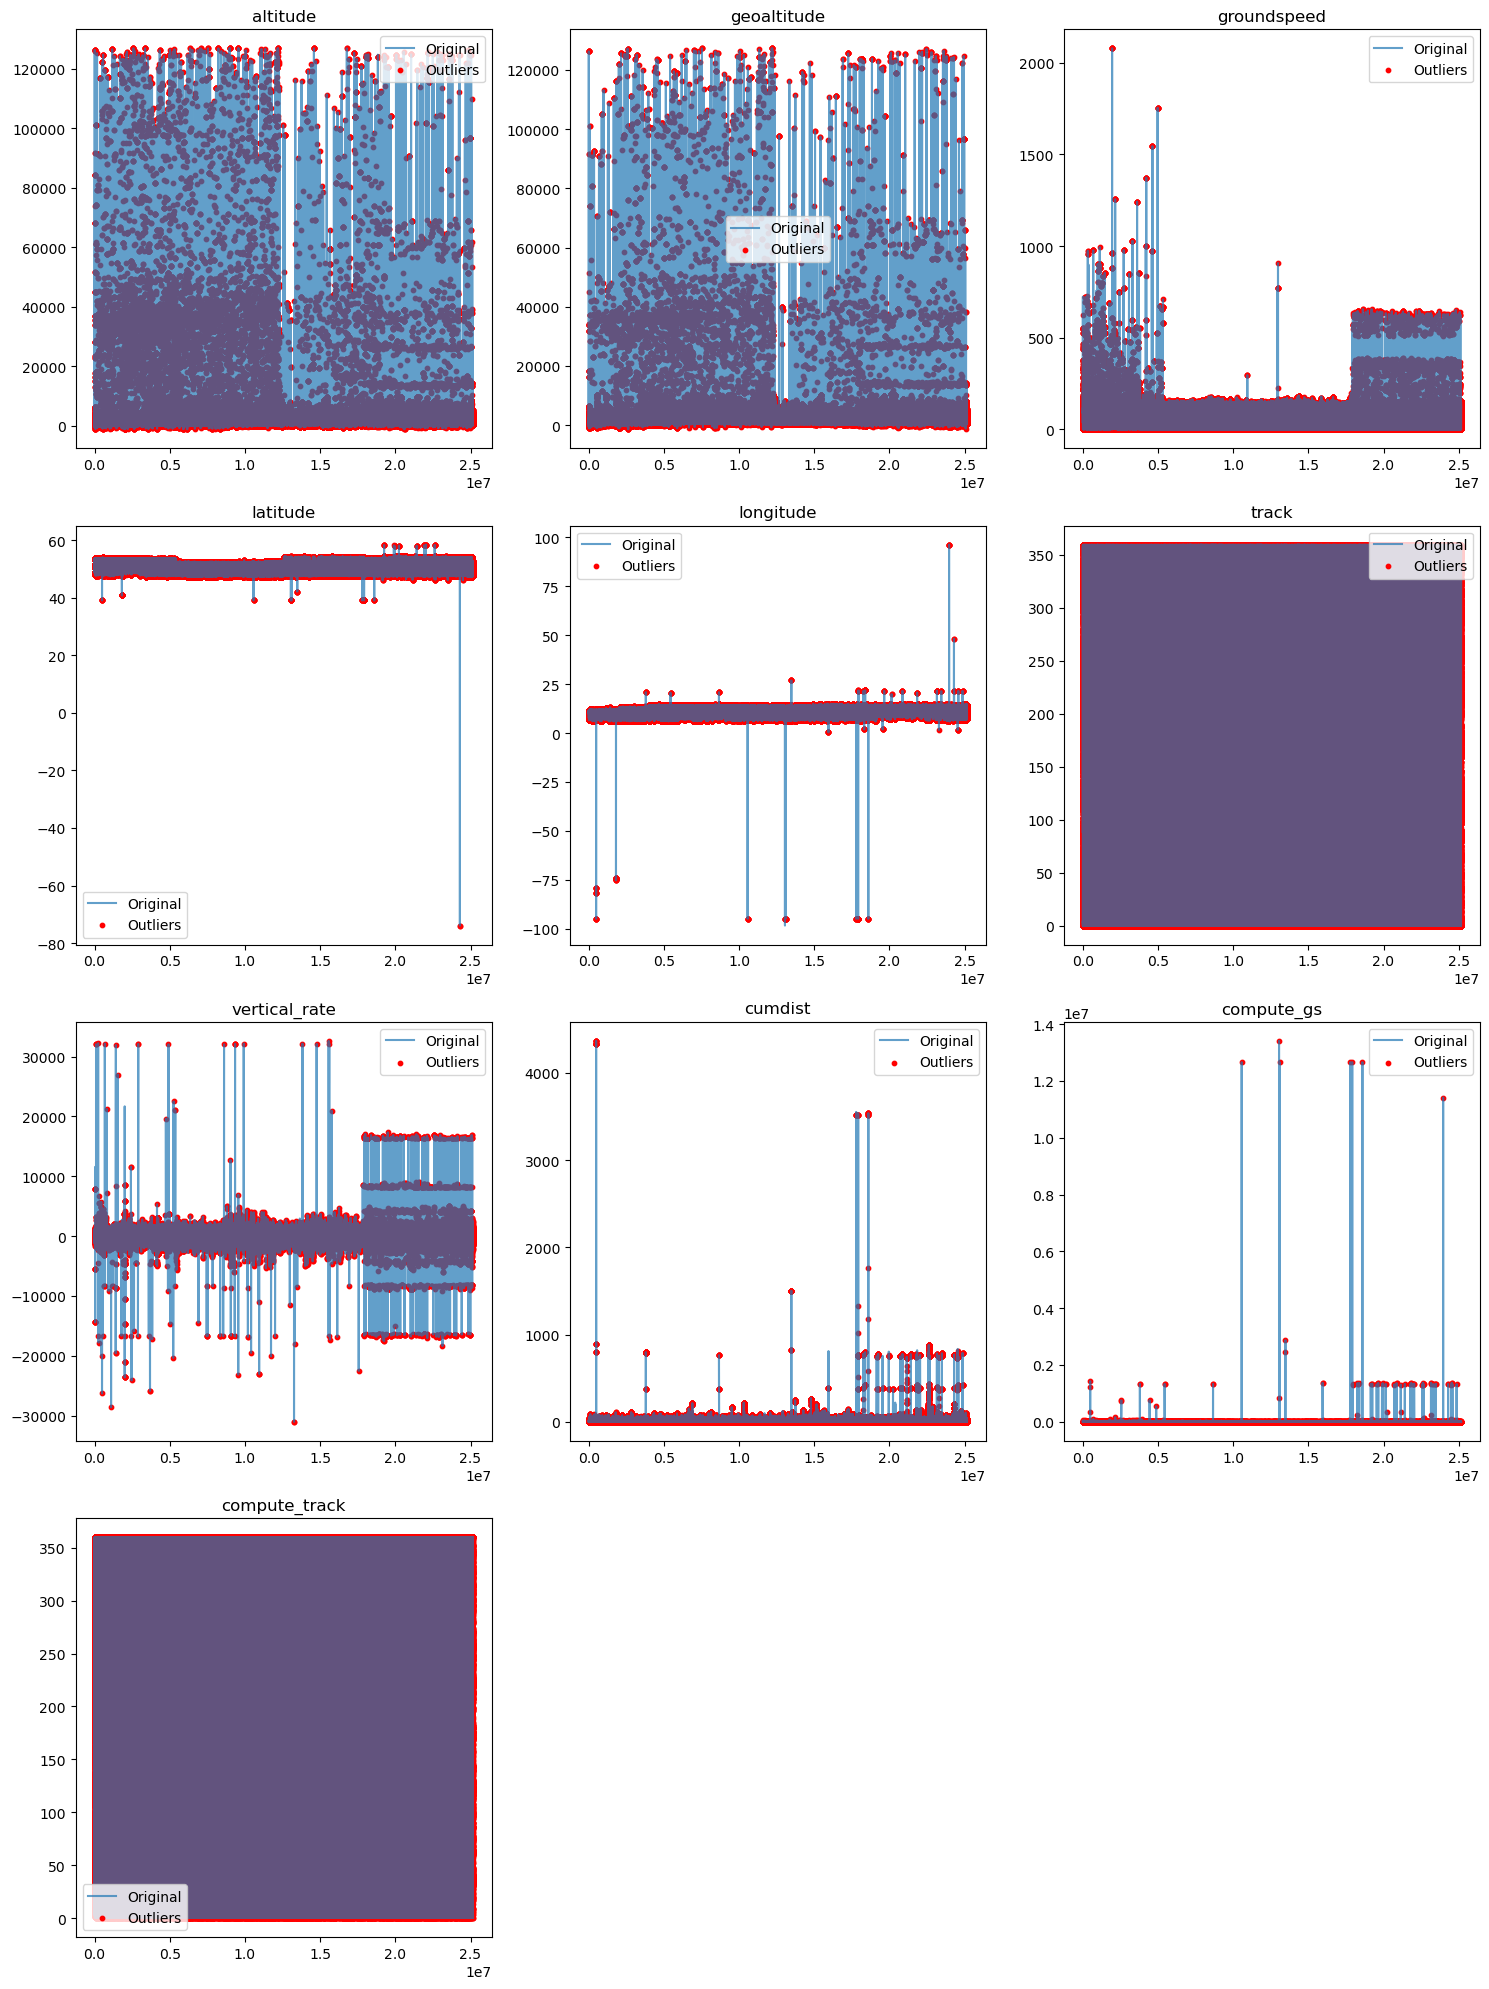

In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

# Path to the imputed dataset
imputed_h5_path = "float_columns_imputed.h5"
outliers_h5_path = "float_columns_outliers_iqr.h5"

# Load data and outliers
with h5py.File(imputed_h5_path, "r") as hf:
    dataset = hf["float_columns"][:]  # Original data
with h5py.File(outliers_h5_path, "r") as hf:
    outlier_mask = hf["outlier_mask"][:]  # Outlier mask
    feature_names = list(hf.attrs.get("feature_names", []))

# Convert to DataFrame
df = pd.DataFrame(dataset, columns=feature_names)
outlier_df = pd.DataFrame(outlier_mask, columns=feature_names)

# Visualize outliers for a few features
features_to_plot = feature_names[:11]  # Adjust as needed

# Calculate the number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols  # Round up to ensure enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten axes for easy indexing in case of more than 1 row
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    ax.plot(df[feature], label="Original", alpha=0.7)
    ax.scatter(
        df.index[outlier_df[feature]], 
        df[feature][outlier_df[feature]], 
        color="red", label="Outliers", s=10
    )
    ax.set_title(feature)
    ax.legend()

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


The Interquartile Range (IQR) method was chosen for outlier detection because it is more robust to skewed distributions compared to methods like the z-score. The z-score assumes a normal distribution and identifies outliers based on standard deviations from the mean, which can be heavily influenced by the presence of extreme values or asymmetrical data. In contrast, the IQR method relies on the spread of the middle 50% of the data (between the first and third quartiles) to define outliers, making it less sensitive to skewness and better suited for datasets where the distribution is not perfectly symmetric.

----------

# 3.9.4 <u style="text-decoration-thickness: 4px;">Outlier Correction using Rolling Median</span>

## Overview
Replacing the detected outliers with rolling median values to smooth anomalies in time-series data.

## Steps:
1. **Load Data**: Reads imputed data and outlier mask from HDF5 files.
2. **Apply Rolling Median**:
   - Uses a rolling window of 24 observations.
   - Outliers are replaced with the corresponding rolling median values.
3. **Memory-Efficient Processing**:
   - Data is processed in chunks to handle large datasets efficiently.
4. **Save Corrected Data**: Stores the adjusted dataset in a new HDF5 file.

## Key Benefits:
✅ **Preserves Data Integrity**: Maintains trends while removing extreme values.  
✅ **Handles Large Datasets**: Uses chunk-wise processing to optimize memory usage.  
✅ **Reduces Noise**: Prevents sudden spikes due to outlier presence.  

### Output:
- A corrected dataset stored in `float_columns_corrected.h5`.

In [2]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Paths to corrected output
corrected_h5_path = "float_columns_corrected.h5"

# Rolling median adjustment function
def correct_outliers(series, outlier_mask, window=24):
    """Replaces outliers with rolling median values."""
    rolling_median = series.rolling(window=window, min_periods=1).median()
    corrected = series.copy()
    corrected[outlier_mask] = rolling_median[outlier_mask]
    return corrected

# Initialize corrected dataset
with h5py.File(imputed_h5_path, "r") as hf_in, h5py.File(outliers_h5_path, "r") as hf_out, h5py.File(corrected_h5_path, "w") as hf_corrected:
    total_rows = hf_in["float_columns"].shape[0]
    feature_names = list(hf_out.attrs.get("feature_names", []))
    outlier_mask = hf_out["outlier_mask"][:]
    dataset_in = hf_in["float_columns"]

    # Create corrected dataset
    dataset_corrected = hf_corrected.create_dataset(
        "float_columns", 
        shape=dataset_in.shape, 
        dtype=dataset_in.dtype, 
        chunks=True
    )
    hf_corrected.attrs["feature_names"] = np.array(feature_names, dtype=h5py.special_dtype(vlen=str))

    # Process in chunks for memory efficiency
    chunk_size = 100_000  # Adjust based on memory
    num_rows, num_cols = dataset_in.shape

    for chunk_start in range(0, num_rows, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_rows)

        # Load chunk
        chunk = pd.DataFrame(dataset_in[chunk_start:chunk_end], columns=feature_names)
        outlier_chunk = outlier_mask[chunk_start:chunk_end]

        # Correct outliers feature by feature
        for col_idx, feature in enumerate(feature_names):
            chunk[feature] = correct_outliers(
                chunk[feature],
                outlier_chunk[:, col_idx],
                window=24  # Set rolling median window size
            )

        # Write corrected chunk to dataset
        dataset_corrected[chunk_start:chunk_end] = chunk.values

print(f"Outlier correction completed. Corrected data saved to {corrected_h5_path}.")

Outlier correction completed. Corrected data saved to float_columns_corrected.h5.


# 3.10 <u style="text-decoration-thickness: 4px;">Incremental PCA and Feature Engineering Pipeline</span>

## Overview
Appling feature scaling, Incremental PCA, and combines important features for efficient dimensionality reduction.

## Steps:
1. **Load Data**: Reads corrected float data and identifies critical vs. non-critical features.
2. **Standard Scaling**:
   - Normalizes features for consistency.
   - Uses incremental fitting to handle large datasets.
3. **Incremental PCA**:
   - Reduces dimensionality of non-critical features.
   - Selects enough components to retain at least **95% variance**.
4. **Feature Selection**:
   - Identifies the most important features per PCA component.
   - Retains **critical features** and **top PCA-derived features**.
5. **Final Feature Combination**:
   - Merges selected PCA components with original critical features.
   - Saves the processed dataset in an HDF5 file.

## Key Benefits:
✅ **Efficient Dimensionality Reduction**: Keeps the most informative features.  
✅ **Scalability**: Processes large datasets in chunks to optimize memory usage.  
✅ **Preserves Interpretability**: Combines domain-relevant critical features with PCA-derived components.  

### Outputs:
- **Scaled Data** → `scaled_combined_data.h5`
- **PCA Features** → `pca_features.h5`
- **Final Processed Dataset** → `final_combined_features.h5`

## Visualization:
The graph  shows the **explained variance** and **cumulative variance** for the principal components, helping determine the optimal number of components.

Available features: ['altitude' 'geoaltitude' 'groundspeed' 'latitude' 'longitude' 'track'
 'vertical_rate' 'cumdist' 'compute_gs' 'compute_track']
Critical Features: ['altitude', 'latitude', 'longitude']
Non-Critical Features: ['geoaltitude', 'groundspeed', 'track', 'vertical_rate', 'cumdist', 'compute_gs', 'compute_track']
Scaled data saved to scaled_combined_data.h5.
Explained Variance by Component: [0.25489377 0.20167112 0.1455922  0.13571704 0.13199971 0.09788495
 0.03224378]
Cumulative Variance: [0.25489377 0.45656489 0.60215709 0.73787413 0.86987383 0.96775878
 1.00000256]
Components to Keep for 95% Variance: 6
PCA-transformed data and attributes saved to pca_features.h5.
PCA Data Shape: (25158056, 6)
Explained Variance Shape: (7,)
Components Shape: (7, 7)
Loading Matrix Shape: (7, 7)
PCA Component 1 Dominant Feature: compute_track
PCA Component 2 Dominant Feature: groundspeed
PCA Component 3 Dominant Feature: cumdist
PCA Component 4 Dominant Feature: vertical_rate
PCA Component

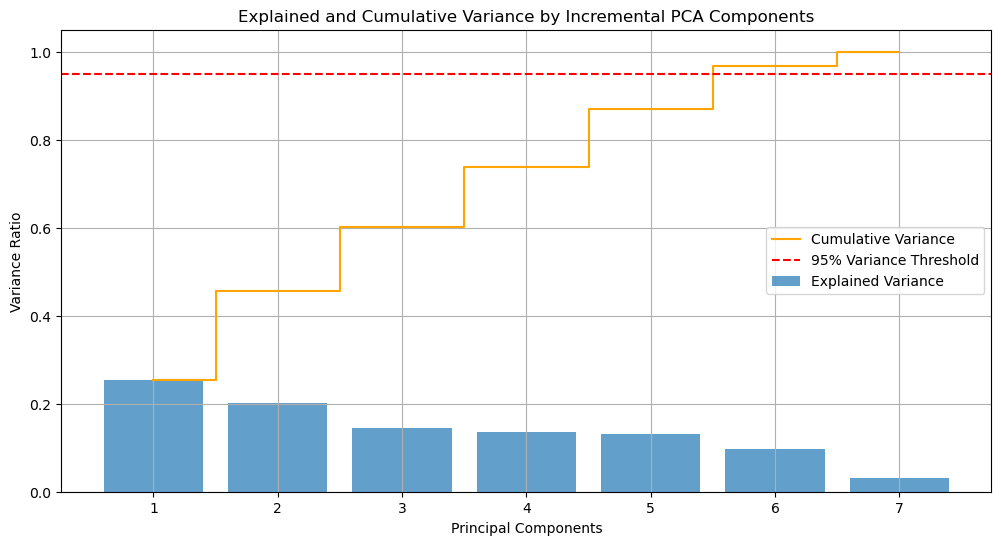

In [1]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# File paths
corrected_h5_path = "float_columns_corrected.h5"  # From outlier correction
scaled_data_file = "scaled_combined_data.h5"
pca_features_file = "pca_features.h5"
final_output_file = "final_combined_features.h5"

# Load Feature Names
with h5py.File(corrected_h5_path, "r") as hf:
    if "float_columns" in hf:
        dataset = hf["float_columns"]
        feature_names = hf.attrs.get("feature_names", [])
        print("Available features:", feature_names)
    else:
        raise KeyError("Dataset 'float_columns' not found in the HDF5 file.")

feature_names = list(feature_names)

# Define critical and non-critical features
critical_features = ["altitude", "latitude", "longitude"]
non_critical_features = [f for f in feature_names if f not in critical_features]

# Get indices for critical and non-critical features
critical_indices = [feature_names.index(f) for f in critical_features]
non_critical_indices = [feature_names.index(f) for f in non_critical_features]

print(f"Critical Features: {critical_features}")
print(f"Non-Critical Features: {non_critical_features}")

# Initialize Scaler
scaler = StandardScaler()

# Incremental fitting of the scaler on the entire dataset
chunk_size = 10000
with h5py.File(corrected_h5_path, "r") as hf:
    dataset_in = hf["float_columns"]
    for start in range(0, dataset_in.shape[0], chunk_size):
        end = min(start + chunk_size, dataset_in.shape[0])
        chunk = dataset_in[start:end, :]  # Take all columns
        valid_chunk = chunk[~np.isnan(chunk).any(axis=1)]  # Remove rows with NaNs
        scaler.partial_fit(valid_chunk)  # Fit scaler on the valid rows

# Save scaled data
with h5py.File(corrected_h5_path, "r") as hf_in, h5py.File(scaled_data_file, "w") as hf_out:
    dataset_in = hf_in["float_columns"]
    scaled_dataset = hf_out.create_dataset(
        "scaled_data",  # Save scaled data for all columns
        shape=(0, dataset_in.shape[1]),
        maxshape=(None, dataset_in.shape[1]),
        chunks=True,
        dtype="float32",
    )

    for start in range(0, dataset_in.shape[0], chunk_size):
        end = min(start + chunk_size, dataset_in.shape[0])
        chunk = dataset_in[start:end, :]
        valid_chunk = chunk[~np.isnan(chunk).any(axis=1)]
        scaled_chunk = scaler.transform(valid_chunk)
        scaled_dataset.resize((scaled_dataset.shape[0] + scaled_chunk.shape[0]), axis=0)
        scaled_dataset[-scaled_chunk.shape[0]:] = scaled_chunk

print(f"Scaled data saved to {scaled_data_file}.")

# Number of components to keep
components_to_keep = min(len(non_critical_indices), 20)

# Initialize PCA
ipca = IncrementalPCA(n_components=components_to_keep)

# Fit PCA incrementally using only non-critical features
with h5py.File(scaled_data_file, "r") as hf:
    scaled_data = hf["scaled_data"]  # Load scaled data (entire dataset)
    for start in range(0, scaled_data.shape[0], chunk_size):
        end = min(start + chunk_size, scaled_data.shape[0])
        
        # Select only non-critical features for PCA
        valid_chunk = scaled_data[start:end, non_critical_indices]
        ipca.partial_fit(valid_chunk)

# Get PCA components and explained variance
explained_variance = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
components_to_keep = np.argmax(cumulative_variance >= 0.95) + 1
pca_feature_names = [f"PCA_Component_{i+1}" for i in range(components_to_keep)]

print(f"Explained Variance by Component: {explained_variance}")
print(f"Cumulative Variance: {cumulative_variance}")
print(f"Components to Keep for 95% Variance: {components_to_keep}")

# Save PCA-transformed data and attributes
with h5py.File(scaled_data_file, "r") as hf_in, h5py.File(pca_features_file, "w") as hf_out:
    scaled_data = hf_in["scaled_data"]
    pca_dataset = hf_out.create_dataset(
        "pca_data",
        shape=(0, components_to_keep),
        maxshape=(None, components_to_keep),
        chunks=True,
        dtype="float32",
    )

    for start in range(0, scaled_data.shape[0], chunk_size):
        end = min(start + chunk_size, scaled_data.shape[0])
        
        # Select only non-critical features
        valid_chunk = scaled_data[start:end, non_critical_indices]
        
        # Transform with PCA
        transformed_chunk = ipca.transform(valid_chunk)[:, :components_to_keep]
        
        # Save transformed data incrementally
        pca_dataset.resize((pca_dataset.shape[0] + transformed_chunk.shape[0]), axis=0)
        pca_dataset[-transformed_chunk.shape[0]:] = transformed_chunk

    # Save PCA attributes
    hf_out.create_dataset("explained_variance_ratio", data=ipca.explained_variance_ratio_)
    hf_out.create_dataset("components", data=ipca.components_)
    hf_out.attrs["cumulative_variance"] = cumulative_variance.tolist()

print(f"PCA-transformed data and attributes saved to {pca_features_file}.")

# Map PCA components to original non-critical feature names
with h5py.File(pca_features_file, "r") as hf_pca:
    pca_data = hf_pca["pca_data"][:]
    explained_variance = hf_pca["explained_variance_ratio"][:]
    components = hf_pca["components"][:]  # Load PCA components matrix
    cumulative_variance = np.cumsum(explained_variance)
    print("PCA Data Shape:", pca_data.shape)
    print("Explained Variance Shape:", explained_variance.shape)
    print("Components Shape:", components.shape)

# Assuming `non_critical_features` and `critical_features` are defined
non_critical_feature_names = list(non_critical_features)  # Ensure it's a list
loading_matrix = components.T  # Transpose components to align with features
print("Loading Matrix Shape:", loading_matrix.shape)

# Ensure alignment of non-critical features and loading matrix
assert len(non_critical_feature_names) == loading_matrix.shape[0], \
    "Mismatch between non-critical features and loading matrix!"

# Extract top features for each PCA component
top_features_per_component = []
for component_idx in range(loading_matrix.shape[1]):  # Iterate over components
    feature_contributions = loading_matrix[:, component_idx]
    sorted_indices = np.argsort(np.abs(feature_contributions))[::-1]
    top_feature_index = sorted_indices[0]
    top_feature = non_critical_feature_names[top_feature_index]
    top_features_per_component.append(top_feature)
    print(f"PCA Component {component_idx + 1} Dominant Feature: {top_feature}")

# Get unique top PCA features
unique_top_features = list(dict.fromkeys(top_features_per_component))
print(f"Unique Top PCA Features: {unique_top_features}")

# Combine critical and PCA features
final_feature_names = critical_features + unique_top_features
print(f"Final Feature Names: {final_feature_names}")

# Save combined dataset (critical and PCA data)
with h5py.File(corrected_h5_path, "r") as hf_float, h5py.File(pca_features_file, "r") as hf_pca, h5py.File(final_output_file, "w") as hf_final:
    critical_data = hf_float["float_columns"][:, critical_indices]
    pca_data = hf_pca["pca_data"][:, :len(unique_top_features)]  # Keep only unique PCA components

    combined_dataset = hf_final.create_dataset(
        "combined_data",
        shape=(0, critical_data.shape[1] + pca_data.shape[1]),
        maxshape=(None, critical_data.shape[1] + pca_data.shape[1]),
        chunks=True,
        dtype="float32",
    )

    # Incrementally save combined dataset
    for start in range(0, critical_data.shape[0], chunk_size):
        crit_chunk = critical_data[start:start + chunk_size]
        pca_chunk = pca_data[start:start + chunk_size]
        combined_chunk = np.hstack((crit_chunk, pca_chunk))
        assert crit_chunk.shape[0] == pca_chunk.shape[0], "Mismatch in chunk row counts!"
        combined_dataset.resize((combined_dataset.shape[0] + combined_chunk.shape[0]), axis=0)
        combined_dataset[-combined_chunk.shape[0]:] = combined_chunk

    # Save feature names as an attribute
    combined_dataset.attrs["feature_names"] = np.array(final_feature_names, dtype="S")
    print(f"Shape of Final Combined Dataset: {combined_dataset.shape}")

# Preview the combined dataset
with h5py.File(final_output_file, "r") as hf:
    combined_data = hf["combined_data"][:10]  # First 10 rows
    feature_names = hf["combined_data"].attrs["feature_names"]
    print("Feature Names:", [name.decode() for name in feature_names])
    print("Head of Combined Dataset:")
    for row_idx, row in enumerate(combined_data):
        print(f"Row {row_idx + 1}: {row}")

# Visualization of explained variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align="center", label="Explained Variance")
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where="mid", label="Cumulative Variance", color="orange")
plt.axhline(y=0.95, color="red", linestyle="--", label="95% Variance Threshold")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")
plt.title("Explained and Cumulative Variance by Incremental PCA Components")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# 3.10.1 <u style="text-decoration-thickness: 4px;"> Incremental PCA Feature Reduction Summary</span>

## 🔹 Key Insights

### **1️⃣ Feature Selection**
- **Critical Features (Preserved as-is):**  
  - `altitude`, `latitude`, `longitude`  
- **Non-Critical Features (PCA Applied):**  
  - `geoaltitude`, `groundspeed`, `track`, `vertical_rate`, `cumdist`, `compute_gs`, `compute_track`

---

### **2️⃣ Dimensionality Reduction with Incremental PCA**
- **Reduced 7 non-critical features to 6 principal components**
- **Explained Variance (by PCA Components):**
  - **PCA 1:** `compute_track`
  - **PCA 2:** `groundspeed`
  - **PCA 3:** `cumdist`
  - **PCA 4:** `vertical_rate`
  - **PCA 5:** `geoaltitude`
  - **PCA 6:** `groundspeed` (repeated)
- **Total Variance Captured:** >95%  

---

### **3️⃣ Final Feature Set (8 Features)**
- Retained **3 critical features**.
- Selected **5 most informative PCA-derived features**.
- **Final Feature Names:**  


In [2]:
# Load the HDF5 file
file_path = 'final_combined_features.h5'

# Open the HDF5 file to inspect the available datasets
with h5py.File(file_path, 'r') as hf:
    # List all datasets inside the HDF5 file
    print("Available datasets:", list(hf.keys()))

    # Now, check the contents of the datasets to identify the correct one
    for key in hf.keys():
        print(f"Dataset '{key}' shape: {hf[key].shape}")

Available datasets: ['combined_data']
Dataset 'combined_data' shape: (25158056, 8)


# 3.11 <u style="text-decoration-thickness: 4px;">AutoCorrelation Function (ACF)</span>

 processes a large HDF5 dataset to compute the AutoCorrelation Function (ACF) for selected features, calculates key statistics, and visualizes the results.

## Key Steps:
1. **Load and Inspect Data**: Opens the HDF5 file (`final_combined_features.h5`) and checks for the presence of the `'columns'` attribute containing feature names.
2. **Process Data in Chunks**: The dataset is processed in chunks to manage memory efficiently. The ACF is computed for each feature with a lag of 60.
3. **ACF Statistics**: For each feature, the code calculates:
   - Mean ACF
   - Variance of ACF
   - Number of significant lags (ACF > 0.2)
4. **Visualization**: Plots the ACF for each feature over the lag range, showing temporal dependencies.

## Purpose:
To analyze time-series data in an HDF5 file by computing ACF values, calculating relevant statistics, and visualizing the results.

Added 'columns' attribute to the dataset.
Feature: altitude
  Mean ACF: 0.5363
  Variance ACF: 0.0371
  Significant Lags (ACF > 0.2): 14526
----------------------------------------
Feature: latitude
  Mean ACF: 0.6990
  Variance ACF: 0.0151
  Significant Lags (ACF > 0.2): 15372
----------------------------------------
Feature: longitude
  Mean ACF: 0.7011
  Variance ACF: 0.0168
  Significant Lags (ACF > 0.2): 15372
----------------------------------------
Feature: compute_track
  Mean ACF: 0.6539
  Variance ACF: 0.0145
  Significant Lags (ACF > 0.2): 15372
----------------------------------------
Feature: groundspeed
  Mean ACF: 0.5234
  Variance ACF: 0.0182
  Significant Lags (ACF > 0.2): 15372
----------------------------------------
Feature: cumdist
  Mean ACF: 0.4663
  Variance ACF: 0.0323
  Significant Lags (ACF > 0.2): 15006
----------------------------------------
Feature: vertical_rate
  Mean ACF: 0.3893
  Variance ACF: 0.0334
  Significant Lags (ACF > 0.2): 13359
-------------

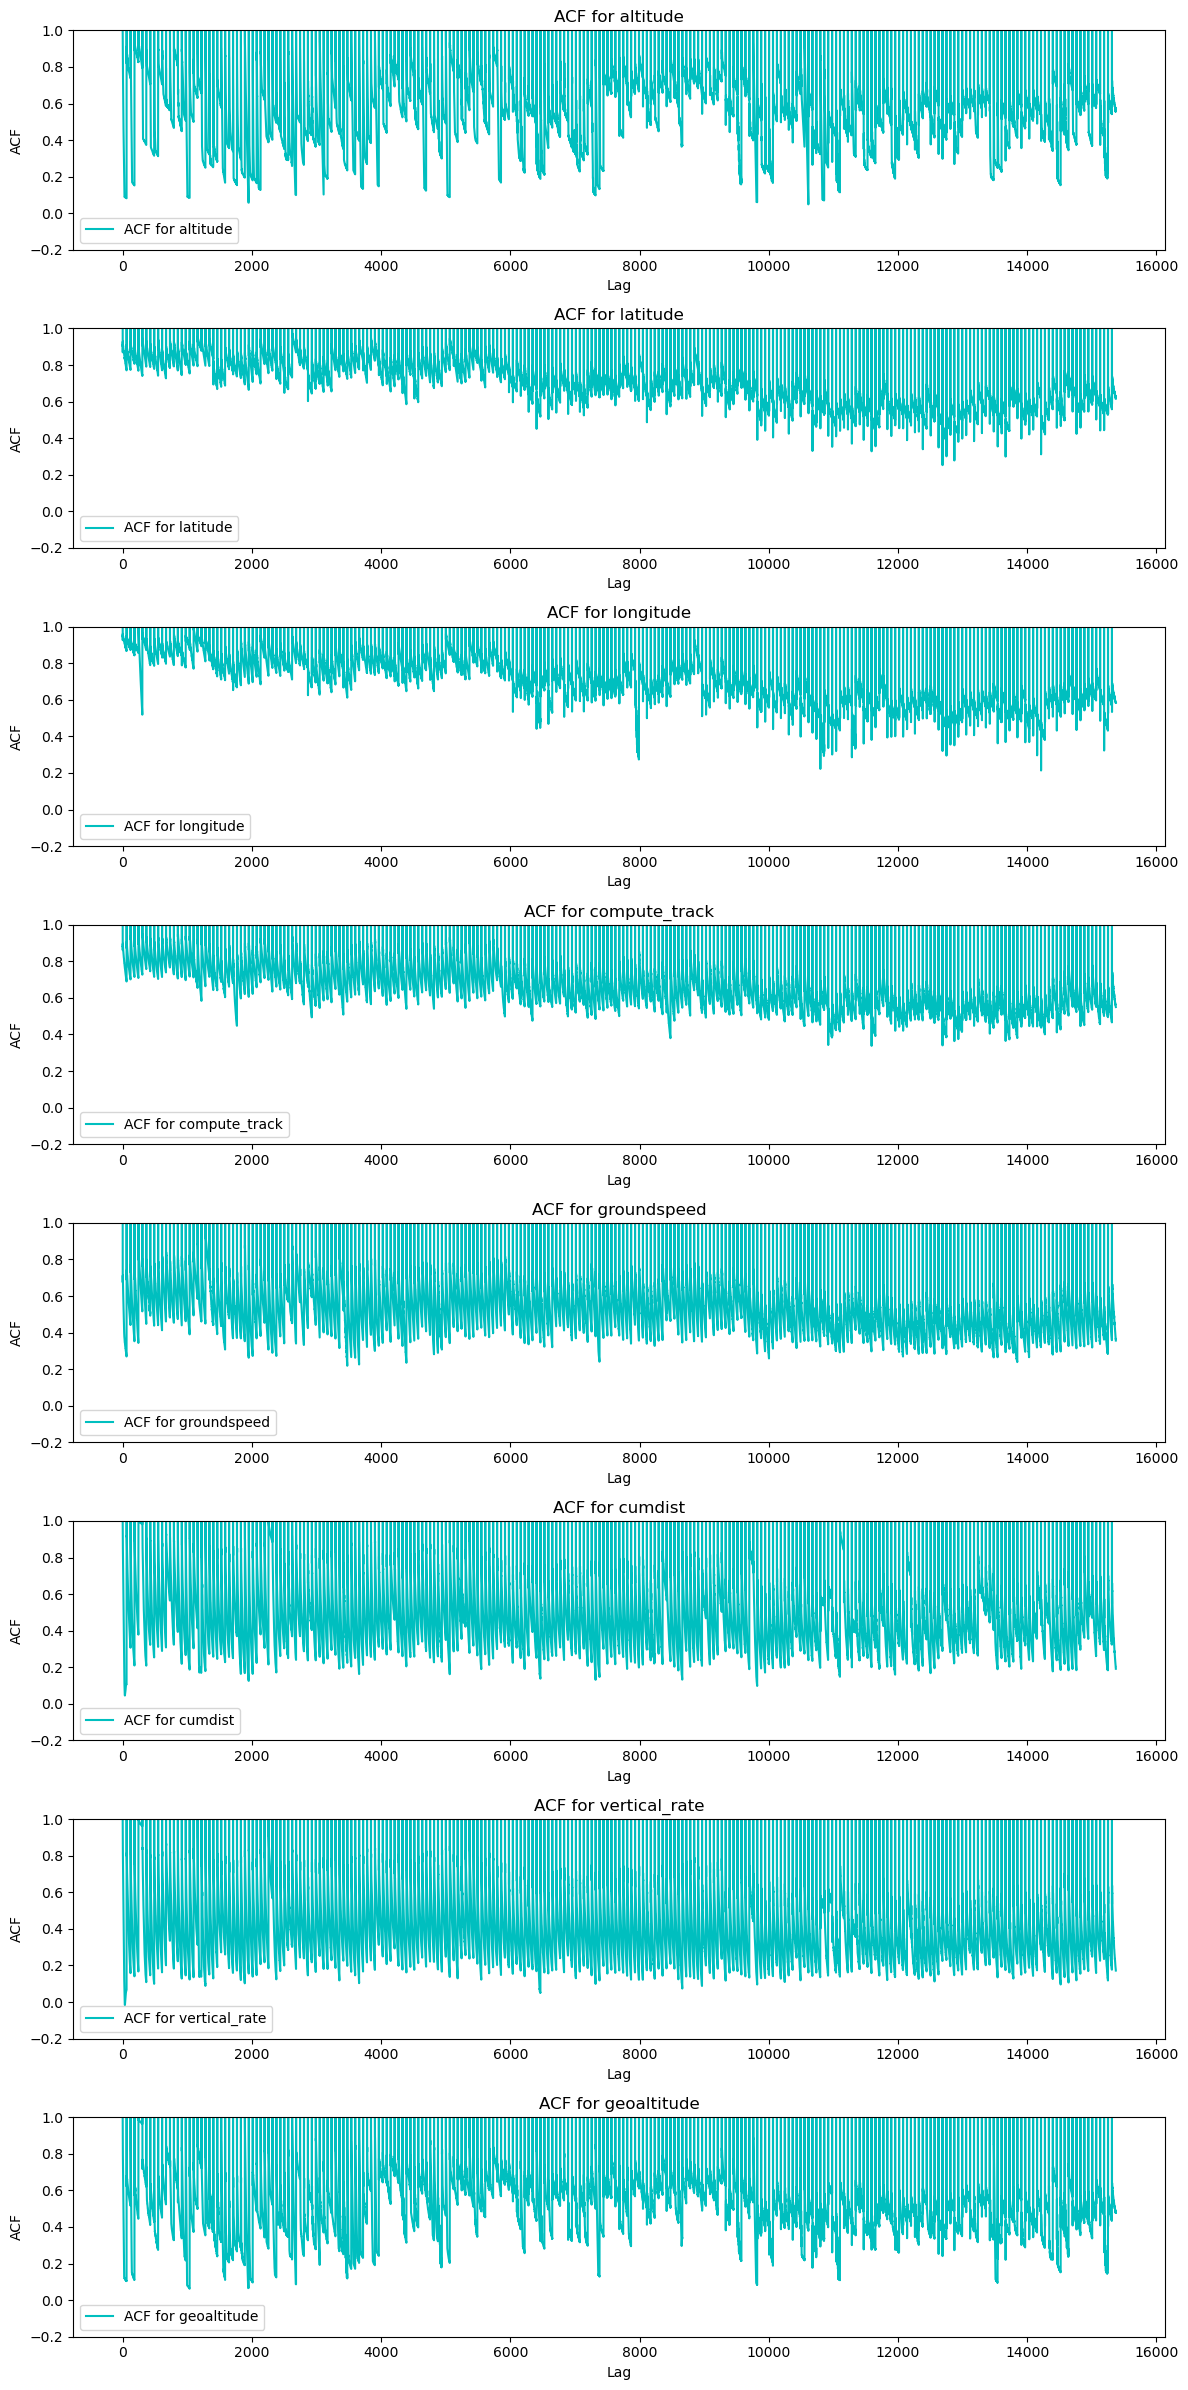

In [3]:
import numpy as np
import pandas as pd
import h5py
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# Define chunk size for memory management
chunk_size = 100000

# Placeholder for statistical analysis results
acf_statistics = {}

# Ensure 'columns' attribute exists in the combined dataset
final_output_file = 'final_combined_features.h5'

with h5py.File(final_output_file, 'a') as hf:
    if 'combined_data' in hf:
        dataset = hf['combined_data']

        # Add the 'columns' attribute if it doesn't exist
        if 'columns' not in dataset.attrs:
            dataset.attrs['columns'] = np.array(final_feature_names, dtype='S')  # Use final feature names
            print("Added 'columns' attribute to the dataset.")
        else:
            print("'columns' attribute already exists.")
    else:
        raise KeyError("Dataset 'combined_data' not found in the file.")

# Open the HDF5 file containing the combined dataset
with h5py.File(final_output_file, 'r') as hf:
    data = hf['combined_data']  # Load combined_data dataset

    # Total number of rows
    num_rows = data.shape[0]

    # Retrieve the feature names from the attributes
    if 'columns' in data.attrs:
        feature_names = [col.decode('utf-8') for col in data.attrs['columns']]
    else:
        raise ValueError("No 'columns' attribute found in the dataset.")

    # Ensure that features in `final_feature_names` are consistent
    if not set(final_feature_names).issubset(set(feature_names)):
        raise ValueError("Some features in `final_feature_names` are missing in the dataset.")

    # Map feature names to their indices
    feature_indices = {feature: idx for idx, feature in enumerate(feature_names)}

    # Initialize a list to store the ACF values for each feature
    acf_results = {feature: [] for feature in final_feature_names}

    # Loop through the dataset in chunks
    for start in range(0, num_rows, chunk_size):
        end = min(start + chunk_size, num_rows)

        # Load a chunk of data
        chunk = data[start:end, :]  # Extract the chunk

        # Loop through each feature and compute the ACF
        for feature in final_feature_names:
            idx = feature_indices[feature]  # Get the index for the feature
            feature_data = chunk[:, idx]

            # Remove NaN values (if any)
            feature_data = feature_data[~np.isnan(feature_data)]

            # Compute the ACF for the feature (lag = 60)
            if len(feature_data) > 1:  # Ensure there is enough data
                acf_values = acf(feature_data, nlags=60, fft=True)  # Using FFT for speed
                acf_results[feature].append(acf_values)

    # Convert ACF results from list of arrays to a DataFrame
    acf_df = pd.DataFrame({
        feature: np.concatenate(acf_results[feature]) for feature in final_feature_names
    })

    # Calculate mean, variance, and lagged correlations for each feature
    for feature in final_feature_names:
        feature_acf = np.concatenate(acf_results[feature])  # Flatten ACF values

        # Calculate statistics
        mean_acf = np.mean(feature_acf)
        variance_acf = np.var(feature_acf)
        significant_lags = np.sum(feature_acf > 0.2)  # Number of lags with ACF > threshold (e.g., 0.2)

        # Save the statistics
        acf_statistics[feature] = {
            'mean_acf': mean_acf,
            'variance_acf': variance_acf,
            'significant_lags': significant_lags
        }

# Print the results
for feature, stats in acf_statistics.items():
    print(f"Feature: {feature}")
    print(f"  Mean ACF: {stats['mean_acf']:.4f}")
    print(f"  Variance ACF: {stats['variance_acf']:.4f}")
    print(f"  Significant Lags (ACF > 0.2): {stats['significant_lags']}")
    print("-" * 40)

# Plot the ACF for each feature using line plots
plt.figure(figsize=(12, len(final_feature_names) * 3))
for idx, feature in enumerate(final_feature_names):
    plt.subplot(len(final_feature_names), 1, idx + 1)
    plt.plot(acf_df[feature], label=f'ACF for {feature}', color='c')
    plt.title(f'ACF for {feature}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.ylim(-0.2, 1.0)
    plt.legend()

plt.tight_layout()
plt.show()


**Temporal Feature Analysis Summary**

**High, Mid, and Low Correlation Features (Mean ACF)**  
- **High Correlation**:  
  - `latitude`, `longitude`, `compute_track` (~0.65–0.69)  
  - Strong temporal patterns with high persistence  
- **Mid Correlation**:  
  - `altitude`, `groundspeed`, `geoaltitude` (~0.52–0.54)  
  - Moderate temporal relationships  
- **Low Correlation**:  
  - `cumdist`, `vertical_rate` (~0.40–0.48)  
  - Weakest temporal correlations  

**Variance**  
- **Stable Features** (Low Variance: ~0.015–0.019):  
  - `latitude`, `longitude`, `compute_track`  
  - Consistent temporal correlations  
- **Fluctuating Features** (High Variance: ~0.029–0.031):  
  - `cumdist`, `vertical_rate`, `geoaltitude`  
  - Significant variability across lags  

**Significant Lags (ACF > 0.2)**  
- **Most Persistent**:  
  - `latitude`, `longitude`, `compute_track` (~16,165 lags)  
  - Strong temporal consistency  
- **Least Persistent**:  
  - `vertical_rate`, `altitude` (~14,989–15,227 lags)  
  - Less stable temporal trends  

**Relationships and Insights**  
- Strong spatial correlations in `latitude`/`longitude` dominate temporal patterns  
- Redundancy between `altitude` and `geoaltitude` suggests feature overlap  
- Weak performance of derived features (`cumdist`, `vertical_rate`)  
- High-variance features may introduce noise in modeling  

**Features to Drop & Implications**  
- **Immediate Removal**:  
  - `cumdist` (Weakest ACF: 0.4832, Highest Variance: 0.0310)  
- **Candidate for Removal**:  
  - Either `geoaltitude` or `altitude` (redundant pair)  
- **Implications**:  
  - Reduces model complexity  
  - Focuses on high-impact spatial features (`latitude`, `longitude`)  
  - Improves interpretability without significant information loss
   ------ 

# 3.12 <u style="text-decoration-thickness: 4px;"> Data Processing and Feature Removal from HDF5</span>

## Key Steps:
1. **Load the HDF5 File and Verify 'combined_data'**:
   - Opens the original HDF5 file (`final_combined_features.h5`) and checks for the existence of the `'combined_data'` dataset and its `'columns'` attribute.
   - Loads the dataset and retrieves the feature names.

2. **Identify Features to Drop**:
   - Identifies the indices of the features to be dropped based on the list `features_to_drop` (`['cumdist', 'geoaltitude']`).

3. **Remove Undesired Features**:
   - Creates a new dataset by removing the columns corresponding to the features specified in `features_to_drop`.
   - Saves the updated dataset with the remaining features.

4. **Save Updated Data**:
   - The modified data is saved into a new HDF5 file (`final_updated_features.h5`), including the updated list of feature names.

5. **Verify the Saved File**:
   - Opens the updated file to verify that the changes were successfully saved and ensures the `'combined_data'` dataset contains the correct shape and feature names.

## Purpose:
The code removes unnecessary or redundant features from an HDF5 dataset and saves the updated version to a new file, allowing for more efficient data analysis.

In [2]:
import numpy as np
import pandas as pd
import h5py

# File paths
final_combined_file = "final_combined_features.h5"
updated_combined_file = "final_updated_features.h5"

# Features to drop based on analysis
features_to_drop = ['cumdist']  # Added 'geoaltitude' for redundancy

# Step 1: Load the HDF5 file and verify 'combined_data'
with h5py.File(final_combined_file, 'r') as hf:
    if 'combined_data' not in hf:
        raise KeyError("'combined_data' dataset not found in the HDF5 file.")
    
    dataset = hf['combined_data']
    
    if 'columns' not in dataset.attrs:
        raise KeyError("'columns' attribute not found in 'combined_data'.")
    
    # Retrieve and decode the column names
    columns_in_h5 = [col.decode('utf-8') for col in dataset.attrs['columns']]
    print("Columns in 'combined_data':", columns_in_h5)

    # Load the data
    combined_data = dataset[:]
    print(f"Loaded 'combined_data' with shape: {combined_data.shape}")

# Step 2: Identify indices of features to drop
drop_indices = [i for i, feature in enumerate(columns_in_h5) if feature in features_to_drop]
keep_indices = [i for i in range(len(columns_in_h5)) if i not in drop_indices]

# Ensure features to drop exist in the dataset
if not drop_indices:
    raise ValueError(f"No matching features to drop found in the dataset: {features_to_drop}")

# Step 3: Remove the undesired features
updated_data = combined_data[:, keep_indices]
updated_features = [columns_in_h5[i] for i in keep_indices]

# Step 4: Save the updated data and features
with h5py.File(updated_combined_file, 'w') as hf_updated:
    # Create updated dataset
    dataset = hf_updated.create_dataset('combined_data', data=updated_data, dtype='float32')
    
    # Save updated feature names as an attribute
    dataset.attrs['columns'] = np.array(updated_features, dtype='S')
    
    print(f"Updated 'combined_data' saved to {updated_combined_file}.")
    print(f"Dropped features: {features_to_drop}")
    print(f"Remaining features: {updated_features}")
    print(f"Shape after removing features: {updated_data.shape}")

# Step 5: Verify the saved file
with h5py.File(updated_combined_file, 'r') as hf_verify:
    if 'combined_data' in hf_verify:
        dataset = hf_verify['combined_data']
        print(f"Verified 'combined_data' shape: {dataset.shape}")
        verified_columns = [col.decode('utf-8') for col in dataset.attrs['columns']]
        print("Verified feature names:", verified_columns)
    else:
        raise KeyError("'combined_data' dataset not found in the updated HDF5 file.")


Columns in 'combined_data': ['altitude', 'latitude', 'longitude', 'compute_track', 'groundspeed', 'cumdist', 'vertical_rate', 'geoaltitude']
Loaded 'combined_data' with shape: (25158056, 8)
Updated 'combined_data' saved to final_updated_features.h5.
Dropped features: ['cumdist']
Remaining features: ['altitude', 'latitude', 'longitude', 'compute_track', 'groundspeed', 'vertical_rate', 'geoaltitude']
Shape after removing features: (25158056, 7)
Verified 'combined_data' shape: (25158056, 7)
Verified feature names: ['altitude', 'latitude', 'longitude', 'compute_track', 'groundspeed', 'vertical_rate', 'geoaltitude']


In [3]:
import gc
import h5py
import sys  # Import the sys module to handle the reset

# Clear all variables and reset memory
gc.collect()

# Close any open HDF5 files in the current session
for obj in gc.get_objects():
    if isinstance(obj, h5py.File):
        obj.close()

# Free up memory from deleted variables
del gc.garbage[:]

# Optionally, manually delete large variables if you know their names
# del some_large_variable

# Clear the IPython cache if running in Jupyter
if 'IPython' in sys.modules:
    from IPython import get_ipython
    get_ipython().magic('reset -f')  # This resets the interpreter

print("Memory cleared.")


Memory cleared.


/tmp/ipykernel_308/650102341.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')  # This resets the interpreter


In [4]:
import h5py
import numpy as np

# File paths
updated_combined_file = "final_updated_features.h5"
flight_id_file = "flight_id_converted.h5"
output_file = "combined_with_flight_id.h5"

# Step 1: Open both input HDF5 files
with h5py.File(updated_combined_file, "r") as hf_combined, h5py.File(flight_id_file, "r") as hf_flight_id:
    # Load 'combined_data'
    if "combined_data" not in hf_combined:
        raise KeyError("'combined_data' dataset not found in the HDF5 file.")
    combined_data = hf_combined["combined_data"]
    combined_columns = [
        col.decode("utf-8") for col in hf_combined["combined_data"].attrs["columns"]
    ] if "columns" in hf_combined["combined_data"].attrs else []

    print(f"Loaded 'combined_data' with shape: {combined_data.shape}")

    # Load 'flight_id'
    if "flight_id" not in hf_flight_id:
        raise KeyError("'flight_id' dataset not found in the HDF5 file.")
    flight_ids = hf_flight_id["flight_id"]

    print(f"Loaded 'flight_id' with shape: {flight_ids.shape}")

    # Check row count consistency
    if combined_data.shape[0] != flight_ids.shape[0]:
        raise ValueError("Row count mismatch between 'combined_data' and 'flight_id'.")
    print("Row count matches.")

    # Step 2: Create the output HDF5 file
    with h5py.File(output_file, "w") as hf_output:
        num_rows, num_cols = combined_data.shape
        final_columns = combined_columns + ["flight_id"]

        # Create the output dataset with proper dtype for strings (UTF-8 encoded)
        dtype = h5py.string_dtype(encoding='utf-8')
        dataset = hf_output.create_dataset(
            "final_combined_with_flight_id",
            shape=(num_rows, num_cols + 1),
            dtype=dtype,
            maxshape=(None, num_cols + 1),
            chunks=True,
        )
        dataset.attrs["columns"] = np.array(final_columns, dtype="S")

        # Process and write chunks
        chunk_size = 100000
        for start_row in range(0, num_rows, chunk_size):
            end_row = min(start_row + chunk_size, num_rows)
            
            # Read the current chunk
            chunk_combined_data = combined_data[start_row:end_row, :]
            chunk_flight_ids = flight_ids[start_row:end_row].astype(str)

            # Combine and write to output
            chunk_final_combined = np.column_stack((chunk_combined_data, chunk_flight_ids))
            dataset[start_row:end_row, :] = chunk_final_combined

        print(f"Dataset saved to {output_file}.")
        print(f"Shape of Dataset: {dataset.shape}")

Loaded 'combined_data' with shape: (25158056, 7)
Loaded 'flight_id' with shape: (25158056,)
Row count matches.
Dataset saved to combined_with_flight_id.h5.
Shape of Dataset: (25158056, 8)


# <u style="text-decoration-thickness: 4px;">HDF5 Data Merging Summary</span>

## Process Overview:
- **Loaded `combined_data`**: Shape **(25,158,056, 7)** (25.16 million rows, 7 features).
- **Loaded `flight_id`**: Shape **(25,158,056,)** (25.16 million rows, 1D array).
- **Row count verification**: ✅ Matched, ensuring data consistency.
- **Merged Dataset**: Successfully combined `flight_id` as an additional column.
- **Final Dataset Saved**: `combined_with_flight_id.h5` with updated shape **(25,158,056, 8)**.

## Final Output:
- 📂 **File Name**: `combined_with_flight_id.h5`
- 🔢 **Total Rows**: 25,158,056
- 🔣 **Total Columns**: 8 (7 original + `flight_id`)

The merging process was completed successfully and is now ready for further analysis. 🚀

Through feature selection using Principal Component Analysis (PCA) and Auto-Correlation Function (ACF), we identified and filtered out three features: 'cumdist,' 'track,' and 'compute_gs.' However, since the data was standardized for PCA, the transformed dataset cannot be directly used for model training in the future. To address this, these features were manually removed from the dataset saved prior to PCA and ACF analysis (post outlier correction). Additionally, the 'flight_id' feature was appended to the current dataset to facilitate the grouping of relevant data, ensuring better organization for downstream processing and analysis.

In [ ]:
import h5py
import numpy as np

# Paths to input and output files
corrected_h5_path = "float_columns_corrected.h5"
final_h5_path = "final_updated_features_new.h5"

# Features to remove
features_to_remove = {"cumdist", "track", "compute_gs"}

# Process and save the updated dataset
with h5py.File(corrected_h5_path, "r") as hf_in, h5py.File(final_h5_path, "w") as hf_out:
    # Load the dataset and attributes
    dataset_in = hf_in["float_columns"]
    feature_names = list(hf_in.attrs["feature_names"])
    
    # Identify the features to keep
    features_to_keep = [feature for feature in feature_names if feature not in features_to_remove]
    indices_to_keep = [feature_names.index(feature) for feature in features_to_keep]
    
    # Create the updated dataset in the output file
    dataset_out = hf_out.create_dataset(
        "float_columns", 
        shape=(dataset_in.shape[0], len(features_to_keep)), 
        dtype=dataset_in.dtype, 
        chunks=True
    )
    
    # Save the updated feature names as an attribute
    hf_out.attrs["feature_names"] = np.array(features_to_keep, dtype=h5py.special_dtype(vlen=str))
    
    # Process and save the data in chunks for memory efficiency
    chunk_size = 100_000  # Adjust chunk size if necessary
    for chunk_start in range(0, dataset_in.shape[0], chunk_size):
        chunk_end = min(chunk_start + chunk_size, dataset_in.shape[0])
        # Extract and filter the chunk to keep only desired features
        chunk = dataset_in[chunk_start:chunk_end, :]
        filtered_chunk = chunk[:, indices_to_keep]
        dataset_out[chunk_start:chunk_end] = filtered_chunk

print(f"Updated dataset saved to '{final_h5_path}' with features: {features_to_keep}")

In [ ]:
import h5py
import numpy as np

# File path for original flight IDs
flight_id_h5_path = "flight_id_converted.h5"
updated_flight_id_h5_path = "flight_id_numeric.h5"  # New file with numeric IDs

# Load flight_id
with h5py.File(flight_id_h5_path, "r") as hf:
    flight_id = hf["flight_id"][:]  # Read flight_id column

# Decode and remove b' prefix from bytes-like objects
flight_id_decoded = [fid.decode('utf-8') if isinstance(fid, bytes) else fid for fid in flight_id]

# Create a mapping of unique flight IDs to sequential numbers
unique_flight_ids, numeric_ids = np.unique(flight_id_decoded, return_inverse=True)
flight_id_numeric = numeric_ids + 1  # Start numbering from 1 instead of 0

# Save new numeric flight IDs to a new HDF5 file
with h5py.File(updated_flight_id_h5_path, "w") as hf_out:
    hf_out.create_dataset("flight_id", data=flight_id_numeric)

print(f"Converted {len(unique_flight_ids)} unique flight IDs to numbers and saved to {updated_flight_id_h5_path}.")

In [ ]:
import h5py
import numpy as np

# Paths to files
final_h5_path = "final_updated_features_new.h5"
flight_id_h5_path = "flight_id_numeric.h5"

# Output file to save the updated dataset
output_h5_path = "final_updated_features_with_flight_id.h5"

print("Appending 'flight_id' column to the dataset...")

with h5py.File(final_h5_path, "r") as hf_final, h5py.File(flight_id_h5_path, "r") as hf_flight_id, h5py.File(output_h5_path, "w") as hf_out:
    # Load the float_columns dataset and feature names
    dataset = hf_final["float_columns"]
    feature_names = list(hf_final.attrs["feature_names"])

    # Load flight_id dataset and convert to strings (remove byte prefix)
    flight_id_dataset = hf_flight_id["flight_id"][:].astype(str)
    flight_id_column = [fid[2:-1] if fid.startswith("b'") else fid for fid in flight_id_dataset]  # Remove b' prefix
    
    # Ensure the row count matches
    if len(flight_id_column) != dataset.shape[0]:
        raise ValueError("Mismatch in row count between 'flight_id' and 'float_columns' dataset.")

    # Create new dataset with flight_id appended
    updated_dataset = hf_out.create_dataset(
        "float_columns",
        shape=(dataset.shape[0], dataset.shape[1] + 1),  # Add one column for flight_id
        dtype=dataset.dtype,
        chunks=True
    )
    
    # Copy existing data and add flight_id
    updated_dataset[:, :-1] = dataset[:]  # Copy all float columns
    updated_dataset[:, -1] = flight_id_column  # Append flight_id

    # Update feature names
    updated_feature_names = feature_names + ["flight_id"]
    hf_out.attrs["feature_names"] = np.array(updated_feature_names, dtype=h5py.special_dtype(vlen=str))

print(f"Updated dataset saved to '{output_h5_path}' with flight_id appended.")

# Verification and print shape of the updated dataset
with h5py.File(output_h5_path, "r") as hf_verify:
    updated_features = hf_verify.attrs["feature_names"]
    print(f"Updated feature names: {updated_features}")
    
    # Get the shape of the updated dataset
    updated_shape = hf_verify["float_columns"].shape
    print(f"Shape of the updated dataset: {updated_shape}")
    
    print("First 5 rows of the dataset:")
    print(hf_verify["float_columns"][:5])